In [1]:
import json
import numpy as np
import os
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import torch

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
df = np.load('../qm9_filtered.npy', allow_pickle = True)

In [4]:
df_X_0 = []
df_y_0 = []
df_X_1 = []
df_y_1 = []
df_X_2 = []
df_y_2 = []
df_X_3 = []
df_y_3 = []
df_X_4 = []
df_y_4 = []

for line in df:
    num = len(line['chiral_centers'])
    
    if num > 5:
        continue
    elif num == 0:
        df_X_0.append(line['xyz'].flatten())
        df_y_0.append(0)
    elif num == 1:
        df_X_1.append(line['xyz'].flatten())
        df_y_1.append(1)
    elif num == 2:
        df_X_2.append(line['xyz'].flatten())
        df_y_2.append(2)
    elif num == 3:
        df_X_3.append(line['xyz'].flatten())
        df_y_3.append(3)
    elif num == 4:
        df_X_4.append(line['xyz'].flatten())
        df_y_4.append(4)
    
df_X_0 = np.array(df_X_0)
df_y_0 = np.array(df_y_0)
df_X_1 = np.array(df_X_1)
df_y_1 = np.array(df_y_1)
df_X_2 = np.array(df_X_2)
df_y_2 = np.array(df_y_2)
df_X_3 = np.array(df_X_3)
df_y_3 = np.array(df_y_3)
df_X_4 = np.array(df_X_4)
df_y_4 = np.array(df_y_4)
    
idx_0 = np.random.choice(np.arange(len(df_y_0)), 10000, replace=False)
df_X_0 = df_X_0[idx_0]
df_y_0 = df_y_0[idx_0]

idx_1 = np.random.choice(np.arange(len(df_y_1)), 10000, replace=False)
df_X_1 = df_X_1[idx_1]
df_y_1 = df_y_1[idx_1]

idx_2 = np.random.choice(np.arange(len(df_y_2)), 10000, replace=False)
df_X_2 = df_X_2[idx_2]
df_y_2 = df_y_2[idx_2]

idx_3 = np.random.choice(np.arange(len(df_y_3)), 10000, replace=False)
df_X_3 = df_X_3[idx_3]
df_y_3 = df_y_3[idx_3]

idx_4 = np.random.choice(np.arange(len(df_y_4)), 10000, replace=False)
df_X_4 = df_X_4[idx_4]
df_y_4 = df_y_4[idx_4]


df_X = np.concatenate((df_X_0, df_X_1, df_X_2, df_X_3, df_X_4), axis=0)
df_y = np.concatenate((df_y_0, df_y_1, df_y_2, df_y_3, df_y_4), axis=0)

In [5]:
print(len(df_X), len(df_y))

50000 50000


In [6]:
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(df_X, df_y, test_size = 0.2)

X_train = torch.from_numpy(X_train_raw).type('torch.FloatTensor')
X_train = X_train.to(device)

y_train = torch.from_numpy(y_train_raw).type('torch.LongTensor')
y_train = y_train.to(device)

X_test = torch.from_numpy(X_test_raw).type('torch.FloatTensor')
X_test = X_test.to(device)

y_test = torch.from_numpy(y_test_raw).type('torch.LongTensor')
y_test = y_test.to(device)

In [7]:
import torch.nn as nn

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.hidden1 = nn.Linear(27*8,500)
        self.hidden2 = nn.Linear(500, 200)
        self.output = nn.Linear(200, 5)
        self.dropout = nn.Dropout(0.05)
        self.Tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self,x):
        x = self.hidden1(x)
        x = self.dropout(x)
        x = self.Tanh(x)
        
        x = self.hidden2(x)
        x = self.dropout(x)
        x = self.Tanh(x)

        x = self.output(x)
        x = self.softmax(x)
        return x
    
    def predict(self,x):
        y_pred = self.forward(x).cpu().detach().numpy()
        y_pred = [np.argmax(sample) for sample in y_pred]
        
        return y_pred
    

net = Net()
net.to(device)

Net(
  (hidden1): Linear(in_features=216, out_features=500, bias=True)
  (hidden2): Linear(in_features=500, out_features=200, bias=True)
  (output): Linear(in_features=200, out_features=5, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
  (Tanh): Tanh()
  (softmax): Softmax(dim=1)
)

In [9]:
net = Net()
net.to(device)
net.load_state_dict(torch.load('torch_num_chiral_dict.dict'))

RuntimeError: Error(s) in loading state_dict for Net:
	size mismatch for output.weight: copying a param with shape torch.Size([9, 20]) from checkpoint, the shape in current model is torch.Size([6, 20]).
	size mismatch for output.bias: copying a param with shape torch.Size([9]) from checkpoint, the shape in current model is torch.Size([6]).

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)
epochs = 200
losses = []
train_accuracies = []
test_accuracies = []
f1s = []

epoch: 0
train_acc: 0.210025
test_acc: 0.2057
f1: 0.19201860527129896

epoch: 1
train_acc: 0.276725
test_acc: 0.2777
f1: 0.2505841012307829

epoch: 2
train_acc: 0.293375
test_acc: 0.2905
f1: 0.25520482089253194

epoch: 3
train_acc: 0.29615
test_acc: 0.2965
f1: 0.25634651301703265

epoch: 4
train_acc: 0.29815
test_acc: 0.2959
f1: 0.2565757855591546

epoch: 5
train_acc: 0.3027
test_acc: 0.2972
f1: 0.2625252083727257

epoch: 6
train_acc: 0.3096
test_acc: 0.3052
f1: 0.2775503304165499

epoch: 7
train_acc: 0.3165
test_acc: 0.3122
f1: 0.29057541469693193

epoch: 8
train_acc: 0.322175
test_acc: 0.3164
f1: 0.30024912243865

epoch: 9
train_acc: 0.32685
test_acc: 0.3224
f1: 0.31029912580928465

epoch: 10
train_acc: 0.3304
test_acc: 0.3296
f1: 0.3207692245916517

epoch: 11
train_acc: 0.33645
test_acc: 0.3388
f1: 0.3311645480797233

epoch: 12
train_acc: 0.342525
test_acc: 0.3424
f1: 0.3344986301396794

epoch: 13
train_acc: 0.345925
test_acc: 0.3481
f1: 0.3387239758867718

epoch: 14
train_acc: 0.34

epoch: 116
train_acc: 0.5473
test_acc: 0.4983
f1: 0.49399276223247396

epoch: 117
train_acc: 0.5472
test_acc: 0.4989
f1: 0.4926361153773293

epoch: 118
train_acc: 0.5515
test_acc: 0.4947
f1: 0.4913086770552275

epoch: 119
train_acc: 0.550275
test_acc: 0.494
f1: 0.4895086604087585

epoch: 120
train_acc: 0.54845
test_acc: 0.497
f1: 0.49362364841620393

epoch: 121
train_acc: 0.55335
test_acc: 0.5052
f1: 0.5000595482727104

epoch: 122
train_acc: 0.554675
test_acc: 0.5
f1: 0.49532297508243917

epoch: 123
train_acc: 0.55545
test_acc: 0.5029
f1: 0.5001527320068161

epoch: 124
train_acc: 0.559075
test_acc: 0.5038
f1: 0.49789301784189693

epoch: 125
train_acc: 0.5603
test_acc: 0.5058
f1: 0.5008423938697346

epoch: 126
train_acc: 0.561425
test_acc: 0.5021
f1: 0.49956596358072186

epoch: 127
train_acc: 0.558275
test_acc: 0.5096
f1: 0.5044220955627998

epoch: 128
train_acc: 0.565175
test_acc: 0.5036
f1: 0.5002028733176537

epoch: 129
train_acc: 0.561225
test_acc: 0.5046
f1: 0.5031631864715722

epo

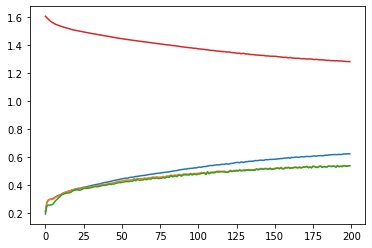

epoch: 0
train_acc: 0.621975
test_acc: 0.5384
f1: 0.5349298857286644

epoch: 1
train_acc: 0.6252
test_acc: 0.5363
f1: 0.536258204750192

epoch: 2
train_acc: 0.62345
test_acc: 0.5405
f1: 0.5399174765852567

epoch: 3
train_acc: 0.62605
test_acc: 0.5403
f1: 0.5368231246586631

epoch: 4
train_acc: 0.62735
test_acc: 0.5424
f1: 0.5415016019155233

epoch: 5
train_acc: 0.624575
test_acc: 0.5393
f1: 0.5383992396341967

epoch: 6
train_acc: 0.624825
test_acc: 0.5401
f1: 0.5380852108432596

epoch: 7
train_acc: 0.628425
test_acc: 0.5398
f1: 0.5391887132790485

epoch: 8
train_acc: 0.62965
test_acc: 0.5418
f1: 0.5404108301903059

epoch: 9
train_acc: 0.6285
test_acc: 0.5379
f1: 0.5352207773905961

epoch: 10
train_acc: 0.6284
test_acc: 0.5433
f1: 0.5427631046163398

epoch: 11
train_acc: 0.630775
test_acc: 0.5425
f1: 0.5410211017643967

epoch: 12
train_acc: 0.63125
test_acc: 0.5472
f1: 0.5448881921456745

epoch: 13
train_acc: 0.630925
test_acc: 0.542
f1: 0.5409004331802362

epoch: 14
train_acc: 0.6344
t

epoch: 119
train_acc: 0.6799
test_acc: 0.5643
f1: 0.5639767282824085

epoch: 120
train_acc: 0.68145
test_acc: 0.5615
f1: 0.5600569703948617

epoch: 121
train_acc: 0.683175
test_acc: 0.5704
f1: 0.570938055176964

epoch: 122
train_acc: 0.6837
test_acc: 0.5636
f1: 0.5633565857821509

epoch: 123
train_acc: 0.6801
test_acc: 0.5631
f1: 0.5596806562084238

epoch: 124
train_acc: 0.685
test_acc: 0.5606
f1: 0.5617030406503475

epoch: 125
train_acc: 0.683125
test_acc: 0.5628
f1: 0.5634767355003105

epoch: 126
train_acc: 0.682675
test_acc: 0.565
f1: 0.5633689937645051

epoch: 127
train_acc: 0.683325
test_acc: 0.565
f1: 0.563731322733249

epoch: 128
train_acc: 0.6827
test_acc: 0.5587
f1: 0.5596115264661242

epoch: 129
train_acc: 0.686
test_acc: 0.5605
f1: 0.5607896420764725

epoch: 130
train_acc: 0.68325
test_acc: 0.5618
f1: 0.5603476979261981

epoch: 131
train_acc: 0.6893
test_acc: 0.5643
f1: 0.5634892351108521

epoch: 132
train_acc: 0.684775
test_acc: 0.5617
f1: 0.562226436423442

epoch: 133
trai

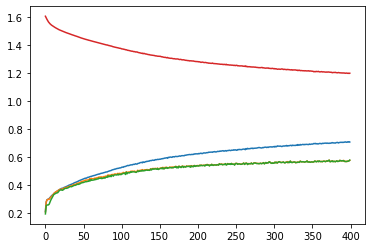

epoch: 0
train_acc: 0.70995
test_acc: 0.5782
f1: 0.5776911252522623

epoch: 1
train_acc: 0.707175
test_acc: 0.5814
f1: 0.5792489087483232

epoch: 2
train_acc: 0.7086
test_acc: 0.5761
f1: 0.5774353487991208

epoch: 3
train_acc: 0.708375
test_acc: 0.5699
f1: 0.5695668596288173

epoch: 4
train_acc: 0.708675
test_acc: 0.5713
f1: 0.5693745658845331

epoch: 5
train_acc: 0.71075
test_acc: 0.5754
f1: 0.5757500378974142

epoch: 6
train_acc: 0.711125
test_acc: 0.5775
f1: 0.5782575347902514

epoch: 7
train_acc: 0.70845
test_acc: 0.5763
f1: 0.576989755840059

epoch: 8
train_acc: 0.70975
test_acc: 0.579
f1: 0.5784753738299542

epoch: 9
train_acc: 0.7128
test_acc: 0.5754
f1: 0.5755986991940019

epoch: 10
train_acc: 0.711125
test_acc: 0.5791
f1: 0.5792776229471008

epoch: 11
train_acc: 0.712975
test_acc: 0.5787
f1: 0.5777281876021584

epoch: 12
train_acc: 0.712325
test_acc: 0.5765
f1: 0.5765410130348522

epoch: 13
train_acc: 0.71255
test_acc: 0.5794
f1: 0.5802847640824516

epoch: 14
train_acc: 0.7122

epoch: 117
train_acc: 0.741025
test_acc: 0.583
f1: 0.5831070079143194

epoch: 118
train_acc: 0.7389
test_acc: 0.5859
f1: 0.5870429272286277

epoch: 119
train_acc: 0.7398
test_acc: 0.5808
f1: 0.5801646545685571

epoch: 120
train_acc: 0.740475
test_acc: 0.5877
f1: 0.588046790273895

epoch: 121
train_acc: 0.741375
test_acc: 0.5887
f1: 0.5883801335457643

epoch: 122
train_acc: 0.741575
test_acc: 0.5847
f1: 0.58425487831598

epoch: 123
train_acc: 0.741225
test_acc: 0.585
f1: 0.5853292295832453

epoch: 124
train_acc: 0.7427
test_acc: 0.5804
f1: 0.5806155719160607

epoch: 125
train_acc: 0.74255
test_acc: 0.587
f1: 0.5864331332106074

epoch: 126
train_acc: 0.7435
test_acc: 0.5897
f1: 0.5907001487860213

epoch: 127
train_acc: 0.7435
test_acc: 0.5819
f1: 0.5837181756509384

epoch: 128
train_acc: 0.74465
test_acc: 0.5873
f1: 0.5870252612838843

epoch: 129
train_acc: 0.7441
test_acc: 0.5807
f1: 0.5792402969521282

epoch: 130
train_acc: 0.744575
test_acc: 0.5825
f1: 0.5831210912723063

epoch: 131
t

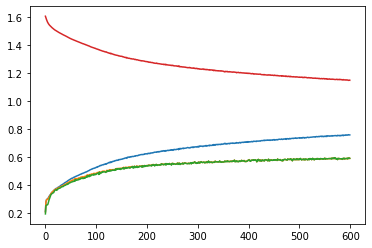

epoch: 0
train_acc: 0.76005
test_acc: 0.5896
f1: 0.590907945067496

epoch: 1
train_acc: 0.759475
test_acc: 0.5926
f1: 0.5925183732440827

epoch: 2
train_acc: 0.7552
test_acc: 0.5926
f1: 0.5919964839491838

epoch: 3
train_acc: 0.761425
test_acc: 0.5885
f1: 0.5885104574902599

epoch: 4
train_acc: 0.76025
test_acc: 0.5902
f1: 0.591459463844033

epoch: 5
train_acc: 0.7591
test_acc: 0.5907
f1: 0.5909015132663124

epoch: 6
train_acc: 0.759725
test_acc: 0.5961
f1: 0.5964255625212067

epoch: 7
train_acc: 0.760275
test_acc: 0.5879
f1: 0.5881102565504648

epoch: 8
train_acc: 0.761125
test_acc: 0.5939
f1: 0.5936313135105167

epoch: 9
train_acc: 0.7603
test_acc: 0.5927
f1: 0.5937036239204883

epoch: 10
train_acc: 0.762325
test_acc: 0.5954
f1: 0.5963140768576488

epoch: 11
train_acc: 0.7618
test_acc: 0.5945
f1: 0.5941778393707389

epoch: 12
train_acc: 0.76245
test_acc: 0.5942
f1: 0.5938749473915951

epoch: 13
train_acc: 0.76095
test_acc: 0.5911
f1: 0.5913245070470754

epoch: 14
train_acc: 0.763925


epoch: 117
train_acc: 0.782825
test_acc: 0.5978
f1: 0.5983059385033048

epoch: 118
train_acc: 0.7798
test_acc: 0.6
f1: 0.5999697767787173

epoch: 119
train_acc: 0.7809
test_acc: 0.5948
f1: 0.5948168289798236

epoch: 120
train_acc: 0.782575
test_acc: 0.5943
f1: 0.594993713387226

epoch: 121
train_acc: 0.78415
test_acc: 0.5986
f1: 0.5991324433150248

epoch: 122
train_acc: 0.782875
test_acc: 0.6011
f1: 0.6014219900776051

epoch: 123
train_acc: 0.7821
test_acc: 0.5973
f1: 0.5974591400808565

epoch: 124
train_acc: 0.782875
test_acc: 0.5968
f1: 0.5977497655427592

epoch: 125
train_acc: 0.782575
test_acc: 0.598
f1: 0.5990022698952057

epoch: 126
train_acc: 0.783575
test_acc: 0.594
f1: 0.5942351380785127

epoch: 127
train_acc: 0.784675
test_acc: 0.5959
f1: 0.5960892693495522

epoch: 128
train_acc: 0.784075
test_acc: 0.5964
f1: 0.5966243700994599

epoch: 129
train_acc: 0.78235
test_acc: 0.5993
f1: 0.5996081150239245

epoch: 130
train_acc: 0.7839
test_acc: 0.598
f1: 0.5978687465045437

epoch: 13

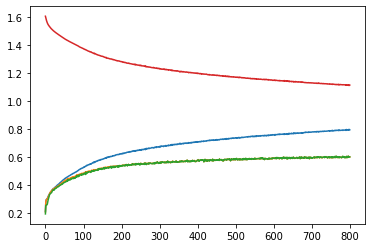

epoch: 0
train_acc: 0.79655
test_acc: 0.6018
f1: 0.6023079706448323

epoch: 1
train_acc: 0.79795
test_acc: 0.6
f1: 0.5999599847935222

epoch: 2
train_acc: 0.79675
test_acc: 0.5957
f1: 0.5961640711019349

epoch: 3
train_acc: 0.796475
test_acc: 0.5956
f1: 0.5959972254618566

epoch: 4
train_acc: 0.799075
test_acc: 0.6067
f1: 0.6070517128876273

epoch: 5
train_acc: 0.79585
test_acc: 0.6032
f1: 0.6034383795284274

epoch: 6
train_acc: 0.796825
test_acc: 0.6033
f1: 0.6036397118993755

epoch: 7
train_acc: 0.7978
test_acc: 0.6013
f1: 0.6018924163554773

epoch: 8
train_acc: 0.7986
test_acc: 0.6032
f1: 0.6033975261504217

epoch: 9
train_acc: 0.796975
test_acc: 0.6028
f1: 0.6021839093547006

epoch: 10
train_acc: 0.799175
test_acc: 0.5989
f1: 0.6002131044921334

epoch: 11
train_acc: 0.7986
test_acc: 0.6036
f1: 0.6047790128634611

epoch: 12
train_acc: 0.79775
test_acc: 0.6065
f1: 0.6073853996488712

epoch: 13
train_acc: 0.79785
test_acc: 0.6003
f1: 0.600946847139553

epoch: 14
train_acc: 0.7985
test

epoch: 118
train_acc: 0.81655
test_acc: 0.6069
f1: 0.6072854777269058

epoch: 119
train_acc: 0.813975
test_acc: 0.6094
f1: 0.6099108210331246

epoch: 120
train_acc: 0.815825
test_acc: 0.6053
f1: 0.6057139385716033

epoch: 121
train_acc: 0.81275
test_acc: 0.61
f1: 0.6105741826283348

epoch: 122
train_acc: 0.8149
test_acc: 0.6134
f1: 0.6142155457181669

epoch: 123
train_acc: 0.8153
test_acc: 0.6058
f1: 0.6062577832605591

epoch: 124
train_acc: 0.81635
test_acc: 0.6075
f1: 0.6077968574741783

epoch: 125
train_acc: 0.814275
test_acc: 0.6066
f1: 0.6073457251697628

epoch: 126
train_acc: 0.81355
test_acc: 0.6072
f1: 0.6075637424791854

epoch: 127
train_acc: 0.815375
test_acc: 0.6045
f1: 0.6045041609537517

epoch: 128
train_acc: 0.81525
test_acc: 0.599
f1: 0.5989822104523568

epoch: 129
train_acc: 0.814475
test_acc: 0.6025
f1: 0.6036496996274544

epoch: 130
train_acc: 0.8158
test_acc: 0.6065
f1: 0.6080275114389099

epoch: 131
train_acc: 0.8145
test_acc: 0.6108
f1: 0.610607836728645

epoch: 13

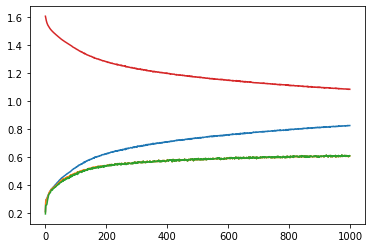

epoch: 0
train_acc: 0.8253
test_acc: 0.6082
f1: 0.6090146810532652

epoch: 1
train_acc: 0.825975
test_acc: 0.6118
f1: 0.6111463637097828

epoch: 2
train_acc: 0.825475
test_acc: 0.609
f1: 0.6089855364773767

epoch: 3
train_acc: 0.824575
test_acc: 0.6042
f1: 0.605289522214691

epoch: 4
train_acc: 0.825825
test_acc: 0.611
f1: 0.6121765684366864

epoch: 5
train_acc: 0.824775
test_acc: 0.6122
f1: 0.611784246308603

epoch: 6
train_acc: 0.826725
test_acc: 0.607
f1: 0.6075921808810255

epoch: 7
train_acc: 0.8266
test_acc: 0.6105
f1: 0.6116629259514195

epoch: 8
train_acc: 0.8258
test_acc: 0.6075
f1: 0.6080412163567821

epoch: 9
train_acc: 0.828
test_acc: 0.6102
f1: 0.6106525461732648

epoch: 10
train_acc: 0.82435
test_acc: 0.611
f1: 0.6118715976576047

epoch: 11
train_acc: 0.825925
test_acc: 0.6093
f1: 0.6098203084556724

epoch: 12
train_acc: 0.8249
test_acc: 0.6065
f1: 0.6069951096249376

epoch: 13
train_acc: 0.826775
test_acc: 0.6099
f1: 0.6102507282391935

epoch: 14
train_acc: 0.8287
test_a

epoch: 117
train_acc: 0.8399
test_acc: 0.6085
f1: 0.6083624275351974

epoch: 118
train_acc: 0.8415
test_acc: 0.6115
f1: 0.611781950393561

epoch: 119
train_acc: 0.841075
test_acc: 0.6068
f1: 0.6080014258142933

epoch: 120
train_acc: 0.839975
test_acc: 0.6048
f1: 0.6053248742065955

epoch: 121
train_acc: 0.839675
test_acc: 0.6111
f1: 0.6114361299553126

epoch: 122
train_acc: 0.839725
test_acc: 0.6112
f1: 0.611153980857069

epoch: 123
train_acc: 0.839925
test_acc: 0.6133
f1: 0.6140166864298069

epoch: 124
train_acc: 0.842275
test_acc: 0.6097
f1: 0.6107914248786772

epoch: 125
train_acc: 0.839775
test_acc: 0.6088
f1: 0.6091367351591671

epoch: 126
train_acc: 0.840725
test_acc: 0.6069
f1: 0.6076898887279358

epoch: 127
train_acc: 0.839975
test_acc: 0.6067
f1: 0.6077793286648534

epoch: 128
train_acc: 0.8411
test_acc: 0.6094
f1: 0.6098838935141834

epoch: 129
train_acc: 0.8408
test_acc: 0.6094
f1: 0.6098485835830024

epoch: 130
train_acc: 0.840675
test_acc: 0.6105
f1: 0.6115043151981235

ep

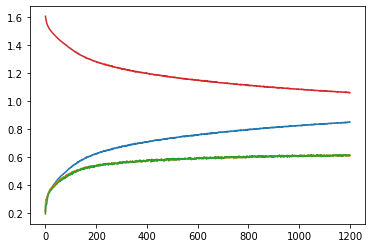

epoch: 0
train_acc: 0.849075
test_acc: 0.6034
f1: 0.6046194113290264

epoch: 1
train_acc: 0.848975
test_acc: 0.6131
f1: 0.6134009106255186

epoch: 2
train_acc: 0.849725
test_acc: 0.608
f1: 0.6084935931731617

epoch: 3
train_acc: 0.848725
test_acc: 0.6098
f1: 0.6103410092732257

epoch: 4
train_acc: 0.84885
test_acc: 0.6162
f1: 0.6178209696565086

epoch: 5
train_acc: 0.8499
test_acc: 0.6183
f1: 0.619460383104211

epoch: 6
train_acc: 0.84895
test_acc: 0.6103
f1: 0.6105731513952254

epoch: 7
train_acc: 0.8479
test_acc: 0.6149
f1: 0.6146532138837283

epoch: 8
train_acc: 0.8501
test_acc: 0.6078
f1: 0.6089994256174015

epoch: 9
train_acc: 0.850275
test_acc: 0.6138
f1: 0.6150895506132885

epoch: 10
train_acc: 0.8503
test_acc: 0.6139
f1: 0.6142770404299251

epoch: 11
train_acc: 0.848925
test_acc: 0.6123
f1: 0.6126314806894884

epoch: 12
train_acc: 0.8512
test_acc: 0.6128
f1: 0.6135755654478745

epoch: 13
train_acc: 0.850075
test_acc: 0.6095
f1: 0.6105067798404361

epoch: 14
train_acc: 0.8501
te

epoch: 117
train_acc: 0.860975
test_acc: 0.6115
f1: 0.6130821357706349

epoch: 118
train_acc: 0.862775
test_acc: 0.6052
f1: 0.6064212912370752

epoch: 119
train_acc: 0.860325
test_acc: 0.6133
f1: 0.6138515722961729

epoch: 120
train_acc: 0.85995
test_acc: 0.6095
f1: 0.6100604888306146

epoch: 121
train_acc: 0.86065
test_acc: 0.6106
f1: 0.6112606590225484

epoch: 122
train_acc: 0.86155
test_acc: 0.6139
f1: 0.6149720816014108

epoch: 123
train_acc: 0.862125
test_acc: 0.6166
f1: 0.6170697606188572

epoch: 124
train_acc: 0.8589
test_acc: 0.6111
f1: 0.6112648490946657

epoch: 125
train_acc: 0.862975
test_acc: 0.6173
f1: 0.6179989777462893

epoch: 126
train_acc: 0.861175
test_acc: 0.6088
f1: 0.6099479169273533

epoch: 127
train_acc: 0.862125
test_acc: 0.6126
f1: 0.6135927343243965

epoch: 128
train_acc: 0.860725
test_acc: 0.6175
f1: 0.6176023419072936

epoch: 129
train_acc: 0.861475
test_acc: 0.612
f1: 0.6123554214334236

epoch: 130
train_acc: 0.863175
test_acc: 0.6118
f1: 0.6126717449876614

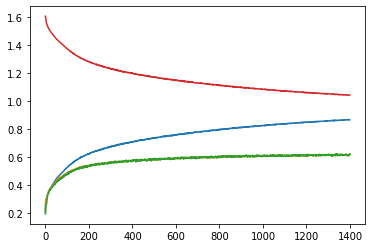

epoch: 0
train_acc: 0.86695
test_acc: 0.6176
f1: 0.6181036444057426

epoch: 1
train_acc: 0.8682
test_acc: 0.6141
f1: 0.6145009994030356

epoch: 2
train_acc: 0.870175
test_acc: 0.6161
f1: 0.6163364918179958

epoch: 3
train_acc: 0.869175
test_acc: 0.6119
f1: 0.6131295933571849

epoch: 4
train_acc: 0.86805
test_acc: 0.6124
f1: 0.6133430315951347

epoch: 5
train_acc: 0.868525
test_acc: 0.6109
f1: 0.612205314442446

epoch: 6
train_acc: 0.8688
test_acc: 0.6171
f1: 0.6178683605182121

epoch: 7
train_acc: 0.867925
test_acc: 0.6088
f1: 0.6092713875867487

epoch: 8
train_acc: 0.868525
test_acc: 0.613
f1: 0.6130525764042073

epoch: 9
train_acc: 0.8678
test_acc: 0.6111
f1: 0.6118143672963804

epoch: 10
train_acc: 0.8695
test_acc: 0.6171
f1: 0.618535628029129

epoch: 11
train_acc: 0.8689
test_acc: 0.6149
f1: 0.6160112469812138

epoch: 12
train_acc: 0.87075
test_acc: 0.6202
f1: 0.6204238843069195

epoch: 13
train_acc: 0.86785
test_acc: 0.6156
f1: 0.6166981517819654

epoch: 14
train_acc: 0.868625
tes

epoch: 117
train_acc: 0.87545
test_acc: 0.6158
f1: 0.6171672599690889

epoch: 118
train_acc: 0.87475
test_acc: 0.6188
f1: 0.6189162290082124

epoch: 119
train_acc: 0.877025
test_acc: 0.6159
f1: 0.6156461186132427

epoch: 120
train_acc: 0.877225
test_acc: 0.616
f1: 0.6171034124753715

epoch: 121
train_acc: 0.87625
test_acc: 0.6057
f1: 0.607953655586838

epoch: 122
train_acc: 0.877325
test_acc: 0.6176
f1: 0.6188618579477425

epoch: 123
train_acc: 0.876875
test_acc: 0.6179
f1: 0.6171281067147242

epoch: 124
train_acc: 0.876425
test_acc: 0.6174
f1: 0.6173279260762089

epoch: 125
train_acc: 0.877725
test_acc: 0.6173
f1: 0.6181018859705404

epoch: 126
train_acc: 0.8769
test_acc: 0.6158
f1: 0.6172525057963008

epoch: 127
train_acc: 0.87695
test_acc: 0.6178
f1: 0.6189046992733749

epoch: 128
train_acc: 0.878725
test_acc: 0.6156
f1: 0.6162650760123204

epoch: 129
train_acc: 0.876575
test_acc: 0.6169
f1: 0.6174488169685085

epoch: 130
train_acc: 0.877125
test_acc: 0.62
f1: 0.6204317178632971

ep

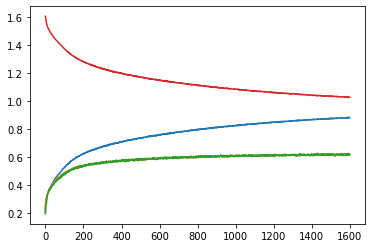

epoch: 0
train_acc: 0.883375
test_acc: 0.6223
f1: 0.6228368866332805

epoch: 1
train_acc: 0.8828
test_acc: 0.617
f1: 0.6179476922510738

epoch: 2
train_acc: 0.8817
test_acc: 0.6151
f1: 0.6160993588381903

epoch: 3
train_acc: 0.884225
test_acc: 0.6173
f1: 0.6178583948060763

epoch: 4
train_acc: 0.88105
test_acc: 0.6101
f1: 0.611169764388621

epoch: 5
train_acc: 0.88205
test_acc: 0.6188
f1: 0.6198720842309197

epoch: 6
train_acc: 0.884575
test_acc: 0.6125
f1: 0.6131663739071727

epoch: 7
train_acc: 0.883525
test_acc: 0.615
f1: 0.6155019578355634

epoch: 8
train_acc: 0.8833
test_acc: 0.6177
f1: 0.6187188767209577

epoch: 9
train_acc: 0.882675
test_acc: 0.6173
f1: 0.6182773537471142

epoch: 10
train_acc: 0.88365
test_acc: 0.6183
f1: 0.619355910425978

epoch: 11
train_acc: 0.884125
test_acc: 0.6179
f1: 0.6185074070155065

epoch: 12
train_acc: 0.883025
test_acc: 0.6189
f1: 0.6190907862934342

epoch: 13
train_acc: 0.883375
test_acc: 0.6116
f1: 0.612191232825898

epoch: 14
train_acc: 0.883025


epoch: 118
train_acc: 0.891025
test_acc: 0.6174
f1: 0.6183219313081518

epoch: 119
train_acc: 0.89005
test_acc: 0.6149
f1: 0.6161333676574855

epoch: 120
train_acc: 0.89135
test_acc: 0.6181
f1: 0.6185919077943781

epoch: 121
train_acc: 0.891125
test_acc: 0.6217
f1: 0.6220067491053475

epoch: 122
train_acc: 0.8897
test_acc: 0.6181
f1: 0.6184741452961627

epoch: 123
train_acc: 0.8915
test_acc: 0.6196
f1: 0.6207883306801892

epoch: 124
train_acc: 0.89195
test_acc: 0.6166
f1: 0.6174931573228695

epoch: 125
train_acc: 0.8915
test_acc: 0.6194
f1: 0.619888787259727

epoch: 126
train_acc: 0.890775
test_acc: 0.6167
f1: 0.6175683651762521

epoch: 127
train_acc: 0.89025
test_acc: 0.6206
f1: 0.6213569889378965

epoch: 128
train_acc: 0.89215
test_acc: 0.6193
f1: 0.6200793203820157

epoch: 129
train_acc: 0.890225
test_acc: 0.618
f1: 0.6186428472296212

epoch: 130
train_acc: 0.891725
test_acc: 0.6182
f1: 0.6191515118576264

epoch: 131
train_acc: 0.89035
test_acc: 0.6177
f1: 0.6185013478073537

epoch:

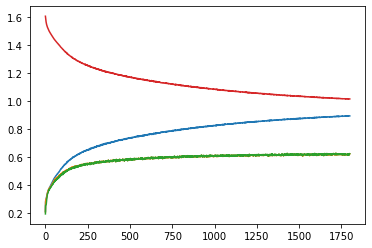

epoch: 0
train_acc: 0.895275
test_acc: 0.6228
f1: 0.6233459933457745

epoch: 1
train_acc: 0.894225
test_acc: 0.6195
f1: 0.6202549290183741

epoch: 2
train_acc: 0.896125
test_acc: 0.6203
f1: 0.6218481342238318

epoch: 3
train_acc: 0.8951
test_acc: 0.6224
f1: 0.6234766748803364

epoch: 4
train_acc: 0.8954
test_acc: 0.621
f1: 0.6215422160947071

epoch: 5
train_acc: 0.8947
test_acc: 0.6263
f1: 0.6260687107230432

epoch: 6
train_acc: 0.89505
test_acc: 0.6172
f1: 0.617543508554856

epoch: 7
train_acc: 0.894275
test_acc: 0.6247
f1: 0.6255818695571889

epoch: 8
train_acc: 0.89485
test_acc: 0.616
f1: 0.617591107342165

epoch: 9
train_acc: 0.896225
test_acc: 0.6127
f1: 0.6138549035290903

epoch: 10
train_acc: 0.8964
test_acc: 0.6203
f1: 0.6204705847218738

epoch: 11
train_acc: 0.89765
test_acc: 0.6147
f1: 0.6148510021144747

epoch: 12
train_acc: 0.89475
test_acc: 0.6193
f1: 0.6200641012297122

epoch: 13
train_acc: 0.8956
test_acc: 0.6179
f1: 0.6190246030741473

epoch: 14
train_acc: 0.896925
test

epoch: 117
train_acc: 0.900875
test_acc: 0.6193
f1: 0.6205334900285521

epoch: 118
train_acc: 0.90125
test_acc: 0.6206
f1: 0.6214406301479964

epoch: 119
train_acc: 0.901075
test_acc: 0.6174
f1: 0.618212094698607

epoch: 120
train_acc: 0.902125
test_acc: 0.6225
f1: 0.6229057485461694

epoch: 121
train_acc: 0.900875
test_acc: 0.6234
f1: 0.6240191432174444

epoch: 122
train_acc: 0.900375
test_acc: 0.618
f1: 0.6194996217239656

epoch: 123
train_acc: 0.901525
test_acc: 0.6191
f1: 0.6198618047149981

epoch: 124
train_acc: 0.901925
test_acc: 0.6183
f1: 0.6192222430454485

epoch: 125
train_acc: 0.9008
test_acc: 0.6172
f1: 0.618231997459718

epoch: 126
train_acc: 0.900775
test_acc: 0.6184
f1: 0.6190577498758913

epoch: 127
train_acc: 0.90115
test_acc: 0.6214
f1: 0.6219763711678603

epoch: 128
train_acc: 0.899775
test_acc: 0.6205
f1: 0.6208451667760645

epoch: 129
train_acc: 0.9015
test_acc: 0.6171
f1: 0.6179175449283439

epoch: 130
train_acc: 0.9011
test_acc: 0.6194
f1: 0.6207308819109488

epo

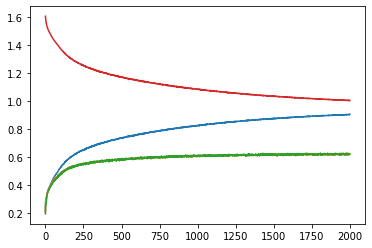

epoch: 0
train_acc: 0.9033
test_acc: 0.6188
f1: 0.619574136537084

epoch: 1
train_acc: 0.905975
test_acc: 0.618
f1: 0.618757044337232

epoch: 2
train_acc: 0.9044
test_acc: 0.618
f1: 0.6189491800825031

epoch: 3
train_acc: 0.905275
test_acc: 0.6211
f1: 0.6218520337717636

epoch: 4
train_acc: 0.9054
test_acc: 0.6189
f1: 0.6196672835636756

epoch: 5
train_acc: 0.905225
test_acc: 0.622
f1: 0.6223069368732702

epoch: 6
train_acc: 0.90455
test_acc: 0.6161
f1: 0.6167016094356784

epoch: 7
train_acc: 0.903175
test_acc: 0.6182
f1: 0.618977369322133

epoch: 8
train_acc: 0.90585
test_acc: 0.6167
f1: 0.6177797162715271

epoch: 9
train_acc: 0.904925
test_acc: 0.6158
f1: 0.6171324913048738

epoch: 10
train_acc: 0.906175
test_acc: 0.6182
f1: 0.6188933955912425

epoch: 11
train_acc: 0.9052
test_acc: 0.6207
f1: 0.621642857258522

epoch: 12
train_acc: 0.905275
test_acc: 0.6213
f1: 0.6221517338152686

epoch: 13
train_acc: 0.9058
test_acc: 0.6219
f1: 0.622365958401262

epoch: 14
train_acc: 0.90465
test_ac

epoch: 117
train_acc: 0.909075
test_acc: 0.6194
f1: 0.6205254174180094

epoch: 118
train_acc: 0.908825
test_acc: 0.6229
f1: 0.6236918479415573

epoch: 119
train_acc: 0.910175
test_acc: 0.6257
f1: 0.6261194965845017

epoch: 120
train_acc: 0.90945
test_acc: 0.6206
f1: 0.6212683637360951

epoch: 121
train_acc: 0.91035
test_acc: 0.6207
f1: 0.6212401711767851

epoch: 122
train_acc: 0.910275
test_acc: 0.6201
f1: 0.6211595831594292

epoch: 123
train_acc: 0.90745
test_acc: 0.6194
f1: 0.6202408031386435

epoch: 124
train_acc: 0.908825
test_acc: 0.6159
f1: 0.6164130473047298

epoch: 125
train_acc: 0.9099
test_acc: 0.6205
f1: 0.6204259076392524

epoch: 126
train_acc: 0.90945
test_acc: 0.6201
f1: 0.620939118863674

epoch: 127
train_acc: 0.909625
test_acc: 0.6211
f1: 0.6222775205662884

epoch: 128
train_acc: 0.9096
test_acc: 0.6194
f1: 0.6200457125898645

epoch: 129
train_acc: 0.91055
test_acc: 0.6221
f1: 0.6226966056712521

epoch: 130
train_acc: 0.9081
test_acc: 0.6196
f1: 0.6208166204701767

epoc

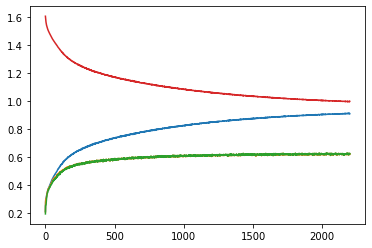

epoch: 0
train_acc: 0.911875
test_acc: 0.6219
f1: 0.6217687959135472

epoch: 1
train_acc: 0.91155
test_acc: 0.6195
f1: 0.6204490604222446

epoch: 2
train_acc: 0.91065
test_acc: 0.617
f1: 0.6184387157472364

epoch: 3
train_acc: 0.9124
test_acc: 0.6241
f1: 0.6248469010355913

epoch: 4
train_acc: 0.911025
test_acc: 0.6217
f1: 0.6227685568129496

epoch: 5
train_acc: 0.9129
test_acc: 0.6206
f1: 0.6211344228358987

epoch: 6
train_acc: 0.912725
test_acc: 0.6196
f1: 0.6203961618311145

epoch: 7
train_acc: 0.9122
test_acc: 0.6177
f1: 0.6185589962504254

epoch: 8
train_acc: 0.912325
test_acc: 0.625
f1: 0.6258565639576295

epoch: 9
train_acc: 0.911325
test_acc: 0.6216
f1: 0.6223333593123832

epoch: 10
train_acc: 0.912275
test_acc: 0.6203
f1: 0.6211608086917815

epoch: 11
train_acc: 0.9127
test_acc: 0.6232
f1: 0.6242162885542002

epoch: 12
train_acc: 0.912225
test_acc: 0.6247
f1: 0.6256880316354198

epoch: 13
train_acc: 0.9132
test_acc: 0.6228
f1: 0.6233225534204742

epoch: 14
train_acc: 0.9128
te

epoch: 118
train_acc: 0.91655
test_acc: 0.6218
f1: 0.6222101457024941

epoch: 119
train_acc: 0.9168
test_acc: 0.6205
f1: 0.6210247761775347

epoch: 120
train_acc: 0.916725
test_acc: 0.6263
f1: 0.6271921997461257

epoch: 121
train_acc: 0.91495
test_acc: 0.6168
f1: 0.617640699947428

epoch: 122
train_acc: 0.915575
test_acc: 0.6182
f1: 0.6199713906092844

epoch: 123
train_acc: 0.916
test_acc: 0.6189
f1: 0.6198683218386962

epoch: 124
train_acc: 0.917025
test_acc: 0.6224
f1: 0.6226707769038676

epoch: 125
train_acc: 0.917125
test_acc: 0.6206
f1: 0.6208813209586895

epoch: 126
train_acc: 0.9159
test_acc: 0.6272
f1: 0.6279137436895075

epoch: 127
train_acc: 0.917025
test_acc: 0.6234
f1: 0.6250389427233858

epoch: 128
train_acc: 0.9154
test_acc: 0.6218
f1: 0.6226397887883839

epoch: 129
train_acc: 0.916675
test_acc: 0.6251
f1: 0.6260743777123638

epoch: 130
train_acc: 0.91615
test_acc: 0.6222
f1: 0.6229636241345033

epoch: 131
train_acc: 0.9164
test_acc: 0.62
f1: 0.6204961413120713

epoch: 13

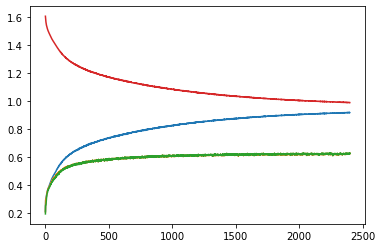

epoch: 0
train_acc: 0.9177
test_acc: 0.6222
f1: 0.6234775404165188

epoch: 1
train_acc: 0.91905
test_acc: 0.6221
f1: 0.6234088695598123

epoch: 2
train_acc: 0.91785
test_acc: 0.6295
f1: 0.6303386877170533

epoch: 3
train_acc: 0.919425
test_acc: 0.6235
f1: 0.624511577663673

epoch: 4
train_acc: 0.917675
test_acc: 0.6194
f1: 0.6204814080241977

epoch: 5
train_acc: 0.91875
test_acc: 0.6167
f1: 0.6175318417379454

epoch: 6
train_acc: 0.917625
test_acc: 0.6254
f1: 0.6265051920984297

epoch: 7
train_acc: 0.919125
test_acc: 0.6255
f1: 0.6264278777535571

epoch: 8
train_acc: 0.9189
test_acc: 0.6215
f1: 0.6220885344330372

epoch: 9
train_acc: 0.9183
test_acc: 0.6188
f1: 0.6187995581137702

epoch: 10
train_acc: 0.918
test_acc: 0.6225
f1: 0.6235154911570419

epoch: 11
train_acc: 0.918075
test_acc: 0.6196
f1: 0.6207961823736555

epoch: 12
train_acc: 0.91935
test_acc: 0.622
f1: 0.6229372201613625

epoch: 13
train_acc: 0.920275
test_acc: 0.623
f1: 0.6232334388724947

epoch: 14
train_acc: 0.919325
te

epoch: 117
train_acc: 0.92265
test_acc: 0.6258
f1: 0.6264036931594776

epoch: 118
train_acc: 0.92265
test_acc: 0.6219
f1: 0.622708429458438

epoch: 119
train_acc: 0.921875
test_acc: 0.6266
f1: 0.62729794519757

epoch: 120
train_acc: 0.92205
test_acc: 0.6245
f1: 0.6252763395363997

epoch: 121
train_acc: 0.92135
test_acc: 0.62
f1: 0.6207614757851779

epoch: 122
train_acc: 0.92155
test_acc: 0.6202
f1: 0.6213235132987368

epoch: 123
train_acc: 0.922525
test_acc: 0.6267
f1: 0.6279661042625441

epoch: 124
train_acc: 0.92285
test_acc: 0.6219
f1: 0.6231212121846696

epoch: 125
train_acc: 0.9222
test_acc: 0.6222
f1: 0.6224644806146357

epoch: 126
train_acc: 0.92305
test_acc: 0.621
f1: 0.6210533734298183

epoch: 127
train_acc: 0.922125
test_acc: 0.6218
f1: 0.6224342248552233

epoch: 128
train_acc: 0.92355
test_acc: 0.6257
f1: 0.6266281699102727

epoch: 129
train_acc: 0.92195
test_acc: 0.6241
f1: 0.625730207035871

epoch: 130
train_acc: 0.92175
test_acc: 0.6225
f1: 0.623848081059874

epoch: 131
t

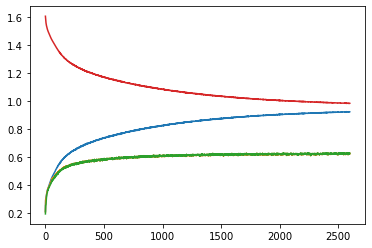

epoch: 0
train_acc: 0.924975
test_acc: 0.6234
f1: 0.624150323550055

epoch: 1
train_acc: 0.92425
test_acc: 0.6211
f1: 0.6218342752589273

epoch: 2
train_acc: 0.9244
test_acc: 0.624
f1: 0.6252118614805968

epoch: 3
train_acc: 0.9226
test_acc: 0.6178
f1: 0.6183624892141425

epoch: 4
train_acc: 0.9247
test_acc: 0.6202
f1: 0.6206456423068575

epoch: 5
train_acc: 0.922675
test_acc: 0.6194
f1: 0.6202190334288598

epoch: 6
train_acc: 0.923925
test_acc: 0.6235
f1: 0.6248375007522703

epoch: 7
train_acc: 0.92375
test_acc: 0.6232
f1: 0.6240792111646511

epoch: 8
train_acc: 0.923425
test_acc: 0.6154
f1: 0.6161001223702127

epoch: 9
train_acc: 0.9231
test_acc: 0.6216
f1: 0.6226914355475472

epoch: 10
train_acc: 0.92575
test_acc: 0.6209
f1: 0.6218342598515932

epoch: 11
train_acc: 0.923975
test_acc: 0.625
f1: 0.62535711487684

epoch: 12
train_acc: 0.924475
test_acc: 0.6298
f1: 0.6304748772129886

epoch: 13
train_acc: 0.92325
test_acc: 0.624
f1: 0.6246153413932681

epoch: 14
train_acc: 0.92495
test_

epoch: 117
train_acc: 0.92725
test_acc: 0.6237
f1: 0.6243842960262822

epoch: 118
train_acc: 0.927475
test_acc: 0.6219
f1: 0.6228534951894326

epoch: 119
train_acc: 0.9276
test_acc: 0.6259
f1: 0.6266667092590263

epoch: 120
train_acc: 0.928
test_acc: 0.6251
f1: 0.625781267627295

epoch: 121
train_acc: 0.927575
test_acc: 0.6232
f1: 0.6235866564586064

epoch: 122
train_acc: 0.925725
test_acc: 0.6311
f1: 0.631576620052797

epoch: 123
train_acc: 0.927125
test_acc: 0.6247
f1: 0.6252144256230561

epoch: 124
train_acc: 0.927325
test_acc: 0.6212
f1: 0.622257610995679

epoch: 125
train_acc: 0.927325
test_acc: 0.6246
f1: 0.6256160076688574

epoch: 126
train_acc: 0.92745
test_acc: 0.6305
f1: 0.6314381905906097

epoch: 127
train_acc: 0.927575
test_acc: 0.621
f1: 0.6214036788745748

epoch: 128
train_acc: 0.926375
test_acc: 0.6267
f1: 0.6276841718549642

epoch: 129
train_acc: 0.927725
test_acc: 0.6308
f1: 0.6318470605553699

epoch: 130
train_acc: 0.9276
test_acc: 0.6266
f1: 0.6276076429748128

epoch

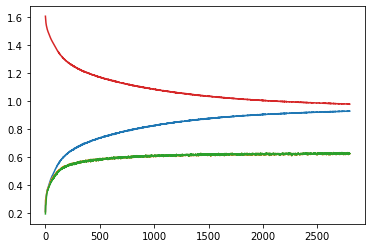

epoch: 0
train_acc: 0.9283
test_acc: 0.6217
f1: 0.6219685232163638

epoch: 1
train_acc: 0.92825
test_acc: 0.6203
f1: 0.6206758436822368

epoch: 2
train_acc: 0.9293
test_acc: 0.6187
f1: 0.6193566792241271

epoch: 3
train_acc: 0.928625
test_acc: 0.6253
f1: 0.6263367798275034

epoch: 4
train_acc: 0.928925
test_acc: 0.6239
f1: 0.624542272809953

epoch: 5
train_acc: 0.927925
test_acc: 0.6219
f1: 0.6222318873378793

epoch: 6
train_acc: 0.93005
test_acc: 0.6224
f1: 0.622811441151145

epoch: 7
train_acc: 0.929175
test_acc: 0.6239
f1: 0.624752029285674

epoch: 8
train_acc: 0.928225
test_acc: 0.6226
f1: 0.6237451324740411

epoch: 9
train_acc: 0.92985
test_acc: 0.625
f1: 0.6265801501043099

epoch: 10
train_acc: 0.930125
test_acc: 0.6249
f1: 0.6261799148854511

epoch: 11
train_acc: 0.92835
test_acc: 0.6224
f1: 0.623292653674808

epoch: 12
train_acc: 0.92785
test_acc: 0.6284
f1: 0.6288521096463999

epoch: 13
train_acc: 0.929225
test_acc: 0.6271
f1: 0.6274543104661583

epoch: 14
train_acc: 0.929875


epoch: 117
train_acc: 0.931675
test_acc: 0.6189
f1: 0.6200986182379746

epoch: 118
train_acc: 0.9327
test_acc: 0.6308
f1: 0.6309712163765359

epoch: 119
train_acc: 0.93175
test_acc: 0.6198
f1: 0.6206058859672287

epoch: 120
train_acc: 0.931375
test_acc: 0.6288
f1: 0.630202296661192

epoch: 121
train_acc: 0.9322
test_acc: 0.6252
f1: 0.6258481661321798

epoch: 122
train_acc: 0.93215
test_acc: 0.6195
f1: 0.619982597210371

epoch: 123
train_acc: 0.931925
test_acc: 0.628
f1: 0.6288551120426386

epoch: 124
train_acc: 0.932725
test_acc: 0.6234
f1: 0.6241394753330862

epoch: 125
train_acc: 0.931575
test_acc: 0.6204
f1: 0.6213898096968565

epoch: 126
train_acc: 0.9313
test_acc: 0.6255
f1: 0.626656976477995

epoch: 127
train_acc: 0.93295
test_acc: 0.6253
f1: 0.6261565085901315

epoch: 128
train_acc: 0.9312
test_acc: 0.6246
f1: 0.6246852747712183

epoch: 129
train_acc: 0.931725
test_acc: 0.6276
f1: 0.6283657705369

epoch: 130
train_acc: 0.931325
test_acc: 0.6247
f1: 0.6254263620743379

epoch: 131

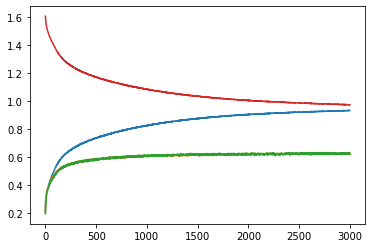

epoch: 0
train_acc: 0.932475
test_acc: 0.6233
f1: 0.6237841594153762

epoch: 1
train_acc: 0.9336
test_acc: 0.6196
f1: 0.6202331458317153

epoch: 2
train_acc: 0.93465
test_acc: 0.6276
f1: 0.62887028832358

epoch: 3
train_acc: 0.9333
test_acc: 0.6257
f1: 0.6260278197535012

epoch: 4
train_acc: 0.933275
test_acc: 0.6226
f1: 0.6232768595102761

epoch: 5
train_acc: 0.932225
test_acc: 0.6241
f1: 0.624521873501325

epoch: 6
train_acc: 0.933375
test_acc: 0.6215
f1: 0.6225116468255839

epoch: 7
train_acc: 0.934225
test_acc: 0.6183
f1: 0.619462164773419

epoch: 8
train_acc: 0.933175
test_acc: 0.6227
f1: 0.623635280735609

epoch: 9
train_acc: 0.933025
test_acc: 0.6276
f1: 0.6281086844116311

epoch: 10
train_acc: 0.9346
test_acc: 0.6203
f1: 0.6205679531281354

epoch: 11
train_acc: 0.9335
test_acc: 0.6262
f1: 0.6269435064893047

epoch: 12
train_acc: 0.933725
test_acc: 0.624
f1: 0.6249353889449176

epoch: 13
train_acc: 0.93405
test_acc: 0.6219
f1: 0.6226593058334708

epoch: 14
train_acc: 0.93365
tes

epoch: 117
train_acc: 0.9354
test_acc: 0.6286
f1: 0.6290419708436014

epoch: 118
train_acc: 0.934025
test_acc: 0.626
f1: 0.6264759971690038

epoch: 119
train_acc: 0.9351
test_acc: 0.622
f1: 0.6221503487247227

epoch: 120
train_acc: 0.936275
test_acc: 0.6296
f1: 0.6302323871808473

epoch: 121
train_acc: 0.93625
test_acc: 0.6216
f1: 0.6222437010062167

epoch: 122
train_acc: 0.936275
test_acc: 0.6227
f1: 0.6238417878966762

epoch: 123
train_acc: 0.935475
test_acc: 0.6267
f1: 0.6277115483586841

epoch: 124
train_acc: 0.9357
test_acc: 0.6198
f1: 0.6206818402929739

epoch: 125
train_acc: 0.93615
test_acc: 0.6252
f1: 0.6261186644777952

epoch: 126
train_acc: 0.935525
test_acc: 0.6221
f1: 0.6231426740098179

epoch: 127
train_acc: 0.935675
test_acc: 0.6236
f1: 0.6244924756660023

epoch: 128
train_acc: 0.936275
test_acc: 0.6171
f1: 0.6179720470313987

epoch: 129
train_acc: 0.9356
test_acc: 0.6261
f1: 0.6267096446337947

epoch: 130
train_acc: 0.936075
test_acc: 0.6204
f1: 0.621266926637323

epoch

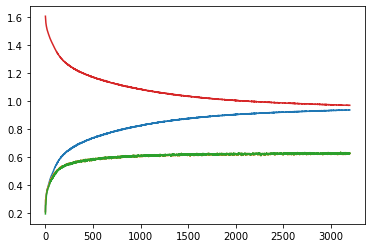

epoch: 0
train_acc: 0.93675
test_acc: 0.6225
f1: 0.6232746260787848

epoch: 1
train_acc: 0.93715
test_acc: 0.6231
f1: 0.6245229442818517

epoch: 2
train_acc: 0.937
test_acc: 0.6207
f1: 0.6219984759753996

epoch: 3
train_acc: 0.935925
test_acc: 0.623
f1: 0.624062991190066

epoch: 4
train_acc: 0.937225
test_acc: 0.6216
f1: 0.6217657097744921

epoch: 5
train_acc: 0.93715
test_acc: 0.628
f1: 0.627995716924857

epoch: 6
train_acc: 0.9377
test_acc: 0.6264
f1: 0.6261924700306921

epoch: 7
train_acc: 0.936425
test_acc: 0.6221
f1: 0.6229106722762036

epoch: 8
train_acc: 0.937375
test_acc: 0.6286
f1: 0.6292545492686915

epoch: 9
train_acc: 0.936925
test_acc: 0.623
f1: 0.6240415761220176

epoch: 10
train_acc: 0.93795
test_acc: 0.6231
f1: 0.623880420036906

epoch: 11
train_acc: 0.93775
test_acc: 0.6315
f1: 0.632139226842176

epoch: 12
train_acc: 0.937775
test_acc: 0.624
f1: 0.6244634448462978

epoch: 13
train_acc: 0.937775
test_acc: 0.6261
f1: 0.6262936254010639

epoch: 14
train_acc: 0.936575
test

epoch: 117
train_acc: 0.93895
test_acc: 0.621
f1: 0.6220073816595395

epoch: 118
train_acc: 0.93995
test_acc: 0.6257
f1: 0.6262588727539867

epoch: 119
train_acc: 0.939425
test_acc: 0.6288
f1: 0.6295717219613596

epoch: 120
train_acc: 0.939225
test_acc: 0.6266
f1: 0.6273410575415052

epoch: 121
train_acc: 0.938425
test_acc: 0.626
f1: 0.6263009372978484

epoch: 122
train_acc: 0.93885
test_acc: 0.622
f1: 0.622391544993536

epoch: 123
train_acc: 0.9385
test_acc: 0.6265
f1: 0.6268450448614462

epoch: 124
train_acc: 0.939225
test_acc: 0.6244
f1: 0.6250997489227766

epoch: 125
train_acc: 0.939375
test_acc: 0.6266
f1: 0.6274111517807641

epoch: 126
train_acc: 0.94015
test_acc: 0.6242
f1: 0.6248219079189107

epoch: 127
train_acc: 0.938725
test_acc: 0.6266
f1: 0.6278877343030452

epoch: 128
train_acc: 0.938675
test_acc: 0.6284
f1: 0.6288644032447702

epoch: 129
train_acc: 0.93865
test_acc: 0.622
f1: 0.6225096379547107

epoch: 130
train_acc: 0.9402
test_acc: 0.6265
f1: 0.627542936148124

epoch: 

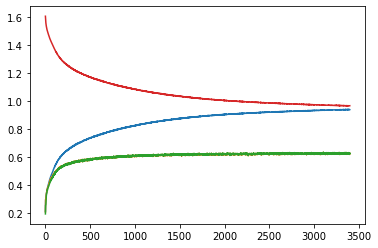

epoch: 0
train_acc: 0.940775
test_acc: 0.6306
f1: 0.6317657202015101

epoch: 1
train_acc: 0.939675
test_acc: 0.6234
f1: 0.6243704990848169

epoch: 2
train_acc: 0.940475
test_acc: 0.6259
f1: 0.626183307330174

epoch: 3
train_acc: 0.941275
test_acc: 0.624
f1: 0.6249113200944164

epoch: 4
train_acc: 0.941
test_acc: 0.6243
f1: 0.6248968300028421

epoch: 5
train_acc: 0.93955
test_acc: 0.6244
f1: 0.6250310285929234

epoch: 6
train_acc: 0.94025
test_acc: 0.6289
f1: 0.6296653532471351

epoch: 7
train_acc: 0.94035
test_acc: 0.6285
f1: 0.6294477694637115

epoch: 8
train_acc: 0.940575
test_acc: 0.626
f1: 0.6265716769411519

epoch: 9
train_acc: 0.94055
test_acc: 0.6267
f1: 0.6275188838263404

epoch: 10
train_acc: 0.94025
test_acc: 0.6286
f1: 0.6288952505195149

epoch: 11
train_acc: 0.940725
test_acc: 0.6205
f1: 0.6211965529075019

epoch: 12
train_acc: 0.940625
test_acc: 0.6266
f1: 0.6275899391422374

epoch: 13
train_acc: 0.9399
test_acc: 0.625
f1: 0.6254389597656407

epoch: 14
train_acc: 0.940125


epoch: 118
train_acc: 0.9417
test_acc: 0.627
f1: 0.6267540592125315

epoch: 119
train_acc: 0.94155
test_acc: 0.6206
f1: 0.6206920869372807

epoch: 120
train_acc: 0.941825
test_acc: 0.6227
f1: 0.6233616135931667

epoch: 121
train_acc: 0.942325
test_acc: 0.6241
f1: 0.6254726859914552

epoch: 122
train_acc: 0.941475
test_acc: 0.6241
f1: 0.6254590252303713

epoch: 123
train_acc: 0.941775
test_acc: 0.6273
f1: 0.6281047033625041

epoch: 124
train_acc: 0.94145
test_acc: 0.6252
f1: 0.6253675586946973

epoch: 125
train_acc: 0.941975
test_acc: 0.6215
f1: 0.6216830459740313

epoch: 126
train_acc: 0.9415
test_acc: 0.6254
f1: 0.6257836050407007

epoch: 127
train_acc: 0.942025
test_acc: 0.6237
f1: 0.6241502191521334

epoch: 128
train_acc: 0.941275
test_acc: 0.6247
f1: 0.626077146311015

epoch: 129
train_acc: 0.94115
test_acc: 0.6226
f1: 0.6236947451480198

epoch: 130
train_acc: 0.9405
test_acc: 0.623
f1: 0.6233462321926566

epoch: 131
train_acc: 0.942175
test_acc: 0.6295
f1: 0.6293950753887295

epoc

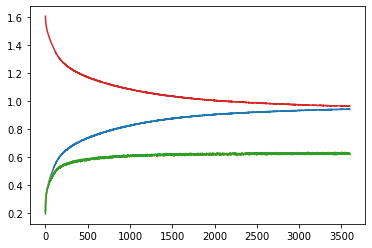

epoch: 0
train_acc: 0.9432
test_acc: 0.627
f1: 0.6269683438408932

epoch: 1
train_acc: 0.9434
test_acc: 0.6288
f1: 0.6293859335348029

epoch: 2
train_acc: 0.942525
test_acc: 0.621
f1: 0.6221626396460994

epoch: 3
train_acc: 0.942575
test_acc: 0.6232
f1: 0.6241956825483757

epoch: 4
train_acc: 0.942125
test_acc: 0.6282
f1: 0.6291781360350728

epoch: 5
train_acc: 0.943575
test_acc: 0.6271
f1: 0.6280970206225054

epoch: 6
train_acc: 0.94245
test_acc: 0.6274
f1: 0.6279084486087552

epoch: 7
train_acc: 0.943125
test_acc: 0.6285
f1: 0.6291421087236918

epoch: 8
train_acc: 0.9425
test_acc: 0.6278
f1: 0.6279220770442124

epoch: 9
train_acc: 0.943475
test_acc: 0.6198
f1: 0.6204083073473893

epoch: 10
train_acc: 0.942825
test_acc: 0.6218
f1: 0.6221325805842346

epoch: 11
train_acc: 0.942975
test_acc: 0.6253
f1: 0.6256374834183731

epoch: 12
train_acc: 0.942825
test_acc: 0.6244
f1: 0.6249057449162223

epoch: 13
train_acc: 0.94385
test_acc: 0.6221
f1: 0.62278016131893

epoch: 14
train_acc: 0.94315

epoch: 117
train_acc: 0.943425
test_acc: 0.6254
f1: 0.6265639539182545

epoch: 118
train_acc: 0.943475
test_acc: 0.6241
f1: 0.624782510808346

epoch: 119
train_acc: 0.9448
test_acc: 0.6257
f1: 0.6260229482889295

epoch: 120
train_acc: 0.94445
test_acc: 0.6203
f1: 0.6206987957829894

epoch: 121
train_acc: 0.944625
test_acc: 0.6259
f1: 0.6268583361278941

epoch: 122
train_acc: 0.9441
test_acc: 0.6199
f1: 0.620790317767404

epoch: 123
train_acc: 0.94425
test_acc: 0.6273
f1: 0.6278456511880054

epoch: 124
train_acc: 0.943975
test_acc: 0.6245
f1: 0.6248845719629297

epoch: 125
train_acc: 0.945275
test_acc: 0.6263
f1: 0.6266589470036285

epoch: 126
train_acc: 0.944425
test_acc: 0.6275
f1: 0.6277553096566315

epoch: 127
train_acc: 0.9449
test_acc: 0.625
f1: 0.6259192739303467

epoch: 128
train_acc: 0.943875
test_acc: 0.6225
f1: 0.6236956225731539

epoch: 129
train_acc: 0.944375
test_acc: 0.6225
f1: 0.6231760234265206

epoch: 130
train_acc: 0.9448
test_acc: 0.6276
f1: 0.6279765544622256

epoch

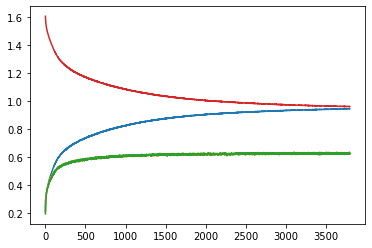

epoch: 0
train_acc: 0.945025
test_acc: 0.6215
f1: 0.6219877703354795

epoch: 1
train_acc: 0.94525
test_acc: 0.6189
f1: 0.6194409357306186

epoch: 2
train_acc: 0.944925
test_acc: 0.6238
f1: 0.6243062870776808

epoch: 3
train_acc: 0.94425
test_acc: 0.6263
f1: 0.626828248967847

epoch: 4
train_acc: 0.944925
test_acc: 0.6248
f1: 0.6259033539928758

epoch: 5
train_acc: 0.9445
test_acc: 0.6226
f1: 0.6233995449546481

epoch: 6
train_acc: 0.945575
test_acc: 0.6332
f1: 0.6340187209399082

epoch: 7
train_acc: 0.94485
test_acc: 0.6208
f1: 0.6207635264862927

epoch: 8
train_acc: 0.945675
test_acc: 0.618
f1: 0.6183747006178152

epoch: 9
train_acc: 0.945675
test_acc: 0.6233
f1: 0.6237962887636003

epoch: 10
train_acc: 0.945075
test_acc: 0.6252
f1: 0.6261924994997364

epoch: 11
train_acc: 0.945975
test_acc: 0.6251
f1: 0.6257130224122116

epoch: 12
train_acc: 0.945025
test_acc: 0.6269
f1: 0.6282591692296777

epoch: 13
train_acc: 0.945425
test_acc: 0.6214
f1: 0.6222121836246317

epoch: 14
train_acc: 0.

epoch: 117
train_acc: 0.946225
test_acc: 0.6226
f1: 0.6228250235130729

epoch: 118
train_acc: 0.946725
test_acc: 0.6283
f1: 0.6287000216171089

epoch: 119
train_acc: 0.946975
test_acc: 0.6226
f1: 0.623228370377954

epoch: 120
train_acc: 0.9467
test_acc: 0.6278
f1: 0.628516433642813

epoch: 121
train_acc: 0.948375
test_acc: 0.6255
f1: 0.6262964723122358

epoch: 122
train_acc: 0.9467
test_acc: 0.6243
f1: 0.6241970652113554

epoch: 123
train_acc: 0.946575
test_acc: 0.6226
f1: 0.6229030277202224

epoch: 124
train_acc: 0.9468
test_acc: 0.6269
f1: 0.6274738444389178

epoch: 125
train_acc: 0.9466
test_acc: 0.6246
f1: 0.6258740390898838

epoch: 126
train_acc: 0.9472
test_acc: 0.6231
f1: 0.6241766258015075

epoch: 127
train_acc: 0.946575
test_acc: 0.6265
f1: 0.6272815410615475

epoch: 128
train_acc: 0.94685
test_acc: 0.624
f1: 0.6243790048128756

epoch: 129
train_acc: 0.9466
test_acc: 0.6212
f1: 0.6215713566351458

epoch: 130
train_acc: 0.9473
test_acc: 0.6289
f1: 0.6297086165852736

epoch: 131

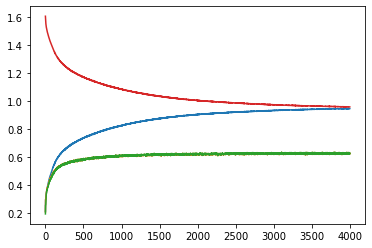

epoch: 0
train_acc: 0.947525
test_acc: 0.6214
f1: 0.6210369349688464

epoch: 1
train_acc: 0.948175
test_acc: 0.6258
f1: 0.6267702431942983

epoch: 2
train_acc: 0.947625
test_acc: 0.6266
f1: 0.627077673984479

epoch: 3
train_acc: 0.947125
test_acc: 0.6242
f1: 0.6250951329579106

epoch: 4
train_acc: 0.947575
test_acc: 0.6216
f1: 0.622980256348293

epoch: 5
train_acc: 0.946875
test_acc: 0.6221
f1: 0.6228286145893004

epoch: 6
train_acc: 0.947425
test_acc: 0.624
f1: 0.6242438474872773

epoch: 7
train_acc: 0.947875
test_acc: 0.6208
f1: 0.6212883347536442

epoch: 8
train_acc: 0.947425
test_acc: 0.6284
f1: 0.6290532070737836

epoch: 9
train_acc: 0.9474
test_acc: 0.6253
f1: 0.6262843089388891

epoch: 10
train_acc: 0.947275
test_acc: 0.6242
f1: 0.625313655442302

epoch: 11
train_acc: 0.94665
test_acc: 0.6203
f1: 0.6209719174754382

epoch: 12
train_acc: 0.94795
test_acc: 0.6288
f1: 0.629501456340793

epoch: 13
train_acc: 0.947925
test_acc: 0.6255
f1: 0.625935524229048

epoch: 14
train_acc: 0.947

epoch: 117
train_acc: 0.94845
test_acc: 0.6275
f1: 0.6280856865293118

epoch: 118
train_acc: 0.948675
test_acc: 0.6216
f1: 0.6226372939733325

epoch: 119
train_acc: 0.9489
test_acc: 0.6254
f1: 0.6268309108689774

epoch: 120
train_acc: 0.949275
test_acc: 0.6293
f1: 0.6301952205246438

epoch: 121
train_acc: 0.948675
test_acc: 0.6261
f1: 0.6261555572267409

epoch: 122
train_acc: 0.94855
test_acc: 0.6259
f1: 0.625984886403709

epoch: 123
train_acc: 0.949925
test_acc: 0.628
f1: 0.6282712224218262

epoch: 124
train_acc: 0.94905
test_acc: 0.6274
f1: 0.6286728328066477

epoch: 125
train_acc: 0.9491
test_acc: 0.6233
f1: 0.6244009187244274

epoch: 126
train_acc: 0.949275
test_acc: 0.6258
f1: 0.6268595658838566

epoch: 127
train_acc: 0.948925
test_acc: 0.6243
f1: 0.6251855023675009

epoch: 128
train_acc: 0.9493
test_acc: 0.6249
f1: 0.6255074202435111

epoch: 129
train_acc: 0.94865
test_acc: 0.6298
f1: 0.6302216973721283

epoch: 130
train_acc: 0.949125
test_acc: 0.6233
f1: 0.6236818682161617

epoc

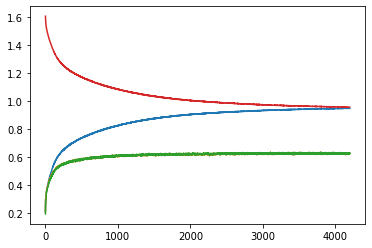

epoch: 0
train_acc: 0.949125
test_acc: 0.6301
f1: 0.6316301953890681

epoch: 1
train_acc: 0.949725
test_acc: 0.6231
f1: 0.6246391341207321

epoch: 2
train_acc: 0.949575
test_acc: 0.6252
f1: 0.6260449192537672

epoch: 3
train_acc: 0.949875
test_acc: 0.626
f1: 0.6261856405809539

epoch: 4
train_acc: 0.949625
test_acc: 0.6322
f1: 0.6318274763270627

epoch: 5
train_acc: 0.948575
test_acc: 0.6267
f1: 0.6267011910154826

epoch: 6
train_acc: 0.949475
test_acc: 0.6251
f1: 0.6255385635008948

epoch: 7
train_acc: 0.948525
test_acc: 0.627
f1: 0.6276564484718512

epoch: 8
train_acc: 0.9497
test_acc: 0.6314
f1: 0.6320811591612262

epoch: 9
train_acc: 0.95
test_acc: 0.6226
f1: 0.6239359462634733

epoch: 10
train_acc: 0.95015
test_acc: 0.6278
f1: 0.6293963434210574

epoch: 11
train_acc: 0.9498
test_acc: 0.6211
f1: 0.6215161449100782

epoch: 12
train_acc: 0.949175
test_acc: 0.624
f1: 0.6243610789028818

epoch: 13
train_acc: 0.9498
test_acc: 0.6261
f1: 0.6264169674890412

epoch: 14
train_acc: 0.9488
te

epoch: 117
train_acc: 0.9506
test_acc: 0.621
f1: 0.621874411453862

epoch: 118
train_acc: 0.9501
test_acc: 0.6256
f1: 0.6262673155414739

epoch: 119
train_acc: 0.950575
test_acc: 0.6266
f1: 0.6267308588149297

epoch: 120
train_acc: 0.950225
test_acc: 0.6274
f1: 0.6275680570654902

epoch: 121
train_acc: 0.951375
test_acc: 0.6303
f1: 0.6306322135942136

epoch: 122
train_acc: 0.9511
test_acc: 0.6243
f1: 0.6251739037089581

epoch: 123
train_acc: 0.950625
test_acc: 0.6242
f1: 0.6249111271424519

epoch: 124
train_acc: 0.95085
test_acc: 0.6233
f1: 0.6241756361460497

epoch: 125
train_acc: 0.95115
test_acc: 0.6237
f1: 0.6246646147494268

epoch: 126
train_acc: 0.9521
test_acc: 0.6212
f1: 0.6217463538431436

epoch: 127
train_acc: 0.949425
test_acc: 0.6294
f1: 0.629751304034784

epoch: 128
train_acc: 0.9505
test_acc: 0.628
f1: 0.6279422211246805

epoch: 129
train_acc: 0.95015
test_acc: 0.6284
f1: 0.628478114285855

epoch: 130
train_acc: 0.950575
test_acc: 0.6281
f1: 0.6285460666619297

epoch: 131

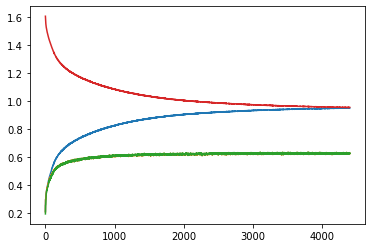

epoch: 0
train_acc: 0.95105
test_acc: 0.6249
f1: 0.6253888617010323

epoch: 1
train_acc: 0.951675
test_acc: 0.6205
f1: 0.6215714998440509

epoch: 2
train_acc: 0.95125
test_acc: 0.6265
f1: 0.6270833249827701

epoch: 3
train_acc: 0.9517
test_acc: 0.6233
f1: 0.6238828937414

epoch: 4
train_acc: 0.951475
test_acc: 0.6263
f1: 0.6267914733953895

epoch: 5
train_acc: 0.94985
test_acc: 0.6222
f1: 0.6218843881396952

epoch: 6
train_acc: 0.95075
test_acc: 0.6302
f1: 0.6303236749479746

epoch: 7
train_acc: 0.95115
test_acc: 0.6244
f1: 0.6246371142742471

epoch: 8
train_acc: 0.950525
test_acc: 0.6233
f1: 0.6244751951582181

epoch: 9
train_acc: 0.950825
test_acc: 0.6284
f1: 0.629653670085704

epoch: 10
train_acc: 0.951025
test_acc: 0.6258
f1: 0.6263851337283789

epoch: 11
train_acc: 0.950775
test_acc: 0.6285
f1: 0.6286434620414657

epoch: 12
train_acc: 0.951225
test_acc: 0.6285
f1: 0.6285995539370931

epoch: 13
train_acc: 0.95155
test_acc: 0.6256
f1: 0.6263712852600604

epoch: 14
train_acc: 0.9508


epoch: 117
train_acc: 0.952475
test_acc: 0.6257
f1: 0.6263867913660867

epoch: 118
train_acc: 0.952825
test_acc: 0.629
f1: 0.6294596467714104

epoch: 119
train_acc: 0.95245
test_acc: 0.6274
f1: 0.6277961587790633

epoch: 120
train_acc: 0.95185
test_acc: 0.6238
f1: 0.6244198488466807

epoch: 121
train_acc: 0.952625
test_acc: 0.622
f1: 0.6223051219435811

epoch: 122
train_acc: 0.95185
test_acc: 0.626
f1: 0.6270387410659974

epoch: 123
train_acc: 0.952225
test_acc: 0.6283
f1: 0.6289329091786638

epoch: 124
train_acc: 0.95195
test_acc: 0.6262
f1: 0.6264957003319239

epoch: 125
train_acc: 0.95225
test_acc: 0.626
f1: 0.6259671301692608

epoch: 126
train_acc: 0.9527
test_acc: 0.6306
f1: 0.6308806449258869

epoch: 127
train_acc: 0.952175
test_acc: 0.6255
f1: 0.6263206857476272

epoch: 128
train_acc: 0.952675
test_acc: 0.6264
f1: 0.6270151432977895

epoch: 129
train_acc: 0.952825
test_acc: 0.6217
f1: 0.6229065071147629

epoch: 130
train_acc: 0.951675
test_acc: 0.6265
f1: 0.6270734407978094

epo

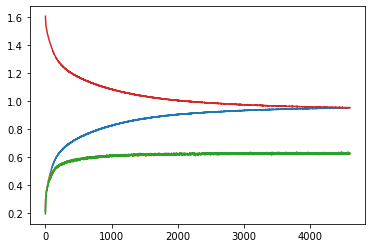

epoch: 0
train_acc: 0.953025
test_acc: 0.6278
f1: 0.6287085935732277

epoch: 1
train_acc: 0.95325
test_acc: 0.6203
f1: 0.6209679530407842

epoch: 2
train_acc: 0.952925
test_acc: 0.6245
f1: 0.6249922191456628

epoch: 3
train_acc: 0.952875
test_acc: 0.6239
f1: 0.6242741183663169

epoch: 4
train_acc: 0.95295
test_acc: 0.6249
f1: 0.6256117803977873

epoch: 5
train_acc: 0.95325
test_acc: 0.6292
f1: 0.6303091812818348

epoch: 6
train_acc: 0.953
test_acc: 0.6267
f1: 0.6274256109299003

epoch: 7
train_acc: 0.9524
test_acc: 0.6284
f1: 0.6289556357593368

epoch: 8
train_acc: 0.952675
test_acc: 0.6281
f1: 0.6284111025473756

epoch: 9
train_acc: 0.953225
test_acc: 0.6319
f1: 0.6323275654335814

epoch: 10
train_acc: 0.952425
test_acc: 0.6292
f1: 0.6298959867357392

epoch: 11
train_acc: 0.952525
test_acc: 0.6275
f1: 0.6280463158198554

epoch: 12
train_acc: 0.95335
test_acc: 0.6295
f1: 0.6299000319471108

epoch: 13
train_acc: 0.95305
test_acc: 0.624
f1: 0.6240762051103074

epoch: 14
train_acc: 0.9533

epoch: 117
train_acc: 0.953975
test_acc: 0.6285
f1: 0.6295385417097056

epoch: 118
train_acc: 0.9552
test_acc: 0.6248
f1: 0.6251359590827589

epoch: 119
train_acc: 0.95315
test_acc: 0.6239
f1: 0.6240879875656534

epoch: 120
train_acc: 0.9542
test_acc: 0.6238
f1: 0.6241700752823368

epoch: 121
train_acc: 0.953975
test_acc: 0.6273
f1: 0.6282801214482808

epoch: 122
train_acc: 0.95405
test_acc: 0.6213
f1: 0.622839067289664

epoch: 123
train_acc: 0.95415
test_acc: 0.6269
f1: 0.6279432582245125

epoch: 124
train_acc: 0.953
test_acc: 0.6304
f1: 0.6309781891287158

epoch: 125
train_acc: 0.9537
test_acc: 0.6303
f1: 0.6306879220491046

epoch: 126
train_acc: 0.9537
test_acc: 0.6255
f1: 0.6257020504499063

epoch: 127
train_acc: 0.953725
test_acc: 0.6273
f1: 0.6278258681985216

epoch: 128
train_acc: 0.954225
test_acc: 0.6284
f1: 0.629188299619111

epoch: 129
train_acc: 0.954275
test_acc: 0.6252
f1: 0.6264744901672448

epoch: 130
train_acc: 0.9534
test_acc: 0.6225
f1: 0.623549849508297

epoch: 131


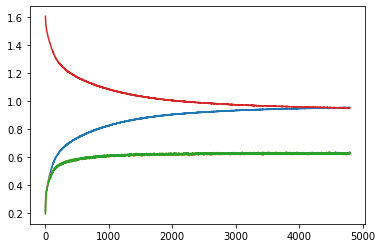

epoch: 0
train_acc: 0.95475
test_acc: 0.6196
f1: 0.6205600596451666

epoch: 1
train_acc: 0.9547
test_acc: 0.6273
f1: 0.628259730527314

epoch: 2
train_acc: 0.9535
test_acc: 0.6268
f1: 0.6274740494387963

epoch: 3
train_acc: 0.953925
test_acc: 0.63
f1: 0.6303225281041301

epoch: 4
train_acc: 0.954625
test_acc: 0.6236
f1: 0.6235896017919194

epoch: 5
train_acc: 0.954325
test_acc: 0.6253
f1: 0.625168547689261

epoch: 6
train_acc: 0.954875
test_acc: 0.6263
f1: 0.6266802805064159

epoch: 7
train_acc: 0.95405
test_acc: 0.6226
f1: 0.6236377633231603

epoch: 8
train_acc: 0.954775
test_acc: 0.6249
f1: 0.6261574638696288

epoch: 9
train_acc: 0.953675
test_acc: 0.6265
f1: 0.6273466507586625

epoch: 10
train_acc: 0.954575
test_acc: 0.6262
f1: 0.6263159292599066

epoch: 11
train_acc: 0.955025
test_acc: 0.6259
f1: 0.6260024117657546

epoch: 12
train_acc: 0.954425
test_acc: 0.6279
f1: 0.6280668552350195

epoch: 13
train_acc: 0.954725
test_acc: 0.6236
f1: 0.624524965245268

epoch: 14
train_acc: 0.9540

epoch: 117
train_acc: 0.9556
test_acc: 0.6245
f1: 0.6246945949746707

epoch: 118
train_acc: 0.954975
test_acc: 0.6192
f1: 0.620020183519459

epoch: 119
train_acc: 0.954325
test_acc: 0.6247
f1: 0.6255514195129351

epoch: 120
train_acc: 0.954675
test_acc: 0.627
f1: 0.6279734171978159

epoch: 121
train_acc: 0.955775
test_acc: 0.6199
f1: 0.6203959899035086

epoch: 122
train_acc: 0.955375
test_acc: 0.6287
f1: 0.6287133036873591

epoch: 123
train_acc: 0.955575
test_acc: 0.6251
f1: 0.625404682463664

epoch: 124
train_acc: 0.9544
test_acc: 0.6243
f1: 0.6248377524715879

epoch: 125
train_acc: 0.9557
test_acc: 0.6286
f1: 0.6296186887759779

epoch: 126
train_acc: 0.955
test_acc: 0.6237
f1: 0.6246200169259234

epoch: 127
train_acc: 0.954925
test_acc: 0.6264
f1: 0.627222668807889

epoch: 128
train_acc: 0.95535
test_acc: 0.6221
f1: 0.6223269614660798

epoch: 129
train_acc: 0.954775
test_acc: 0.6268
f1: 0.6273900463351262

epoch: 130
train_acc: 0.95495
test_acc: 0.6242
f1: 0.624500517964489

epoch: 1

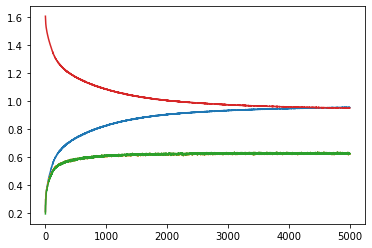

epoch: 0
train_acc: 0.9551
test_acc: 0.6271
f1: 0.6272912189103951

epoch: 1
train_acc: 0.9549
test_acc: 0.6236
f1: 0.6242690204517078

epoch: 2
train_acc: 0.95555
test_acc: 0.6285
f1: 0.6290182638093403

epoch: 3
train_acc: 0.955225
test_acc: 0.6285
f1: 0.6294031728124508

epoch: 4
train_acc: 0.955475
test_acc: 0.624
f1: 0.625473909657679

epoch: 5
train_acc: 0.95535
test_acc: 0.6265
f1: 0.6273969373276297

epoch: 6
train_acc: 0.9556
test_acc: 0.6278
f1: 0.6285495804040918

epoch: 7
train_acc: 0.956225
test_acc: 0.6278
f1: 0.6281327124841705

epoch: 8
train_acc: 0.955675
test_acc: 0.6244
f1: 0.6245922212548433

epoch: 9
train_acc: 0.954975
test_acc: 0.6257
f1: 0.6255912444807231

epoch: 10
train_acc: 0.955725
test_acc: 0.6253
f1: 0.6256506540423262

epoch: 11
train_acc: 0.95565
test_acc: 0.6295
f1: 0.629750916314568

epoch: 12
train_acc: 0.9549
test_acc: 0.6203
f1: 0.6208856618583101

epoch: 13
train_acc: 0.955325
test_acc: 0.6258
f1: 0.626789328598114

epoch: 14
train_acc: 0.9549
tes

epoch: 117
train_acc: 0.957225
test_acc: 0.6237
f1: 0.6239772145001682

epoch: 118
train_acc: 0.9569
test_acc: 0.6193
f1: 0.6195009200206195

epoch: 119
train_acc: 0.9557
test_acc: 0.6208
f1: 0.6213213182774582

epoch: 120
train_acc: 0.955425
test_acc: 0.6272
f1: 0.6276893387935567

epoch: 121
train_acc: 0.956275
test_acc: 0.6252
f1: 0.6257432037808267

epoch: 122
train_acc: 0.95665
test_acc: 0.6282
f1: 0.6285956546545445

epoch: 123
train_acc: 0.956325
test_acc: 0.6277
f1: 0.627858553306927

epoch: 124
train_acc: 0.95635
test_acc: 0.6218
f1: 0.6223299907420773

epoch: 125
train_acc: 0.957125
test_acc: 0.6251
f1: 0.6254084819229531

epoch: 126
train_acc: 0.9569
test_acc: 0.6257
f1: 0.6258208544539611

epoch: 127
train_acc: 0.9563
test_acc: 0.6216
f1: 0.6218809332016638

epoch: 128
train_acc: 0.955725
test_acc: 0.62
f1: 0.6205449339406393

epoch: 129
train_acc: 0.95605
test_acc: 0.6265
f1: 0.6266495866024447

epoch: 130
train_acc: 0.95635
test_acc: 0.63
f1: 0.6305940274901354

epoch: 13

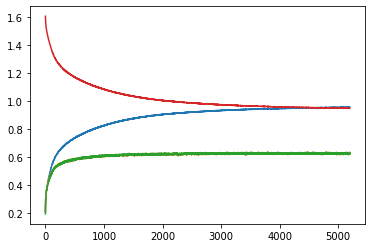

epoch: 0
train_acc: 0.95625
test_acc: 0.6194
f1: 0.6201279186167057

epoch: 1
train_acc: 0.956675
test_acc: 0.6253
f1: 0.6259036665789226

epoch: 2
train_acc: 0.956025
test_acc: 0.6261
f1: 0.6265643758948684

epoch: 3
train_acc: 0.957125
test_acc: 0.6251
f1: 0.6256667101211004

epoch: 4
train_acc: 0.956975
test_acc: 0.6209
f1: 0.6210294324130374

epoch: 5
train_acc: 0.956575
test_acc: 0.6234
f1: 0.6233103711174378

epoch: 6
train_acc: 0.956675
test_acc: 0.6282
f1: 0.6283506048231752

epoch: 7
train_acc: 0.9565
test_acc: 0.6235
f1: 0.6234838840266502

epoch: 8
train_acc: 0.956425
test_acc: 0.6237
f1: 0.6244553979748493

epoch: 9
train_acc: 0.956075
test_acc: 0.6263
f1: 0.6269251886088025

epoch: 10
train_acc: 0.9567
test_acc: 0.6239
f1: 0.6250511356701102

epoch: 11
train_acc: 0.9566
test_acc: 0.6232
f1: 0.6243184011916622

epoch: 12
train_acc: 0.9571
test_acc: 0.6245
f1: 0.6250393213003849

epoch: 13
train_acc: 0.957575
test_acc: 0.6256
f1: 0.6258953678841028

epoch: 14
train_acc: 0.95

epoch: 117
train_acc: 0.95755
test_acc: 0.6257
f1: 0.6255515235760766

epoch: 118
train_acc: 0.957525
test_acc: 0.6262
f1: 0.6262271025968573

epoch: 119
train_acc: 0.9575
test_acc: 0.6266
f1: 0.627295054197588

epoch: 120
train_acc: 0.95805
test_acc: 0.6232
f1: 0.623553819556533

epoch: 121
train_acc: 0.957525
test_acc: 0.628
f1: 0.6286466524502692

epoch: 122
train_acc: 0.9572
test_acc: 0.6249
f1: 0.6255308731177951

epoch: 123
train_acc: 0.95685
test_acc: 0.6232
f1: 0.6234849780781713

epoch: 124
train_acc: 0.957025
test_acc: 0.624
f1: 0.6238125122607222

epoch: 125
train_acc: 0.95705
test_acc: 0.6291
f1: 0.6289573669206974

epoch: 126
train_acc: 0.9577
test_acc: 0.6264
f1: 0.6270919502867893

epoch: 127
train_acc: 0.9577
test_acc: 0.6243
f1: 0.6253208137900004

epoch: 128
train_acc: 0.9572
test_acc: 0.6253
f1: 0.6262328131047971

epoch: 129
train_acc: 0.95705
test_acc: 0.6224
f1: 0.6231569054681872

epoch: 130
train_acc: 0.957025
test_acc: 0.6263
f1: 0.625744754690516

epoch: 131
t

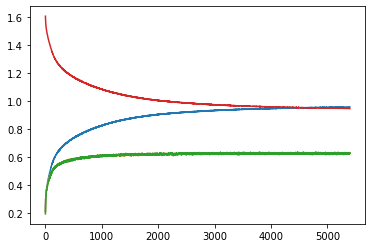

epoch: 0
train_acc: 0.95725
test_acc: 0.6252
f1: 0.6250591768502332

epoch: 1
train_acc: 0.956725
test_acc: 0.628
f1: 0.6284773914302448

epoch: 2
train_acc: 0.95785
test_acc: 0.6223
f1: 0.6228502938506862

epoch: 3
train_acc: 0.958
test_acc: 0.628
f1: 0.629729627526607

epoch: 4
train_acc: 0.957225
test_acc: 0.6275
f1: 0.6286317979239626

epoch: 5
train_acc: 0.958325
test_acc: 0.6274
f1: 0.6279097706583274

epoch: 6
train_acc: 0.958275
test_acc: 0.6282
f1: 0.6274786901183139

epoch: 7
train_acc: 0.957025
test_acc: 0.6297
f1: 0.6287794709756352

epoch: 8
train_acc: 0.958175
test_acc: 0.6302
f1: 0.6298237514958326

epoch: 9
train_acc: 0.958225
test_acc: 0.6255
f1: 0.6257963476645283

epoch: 10
train_acc: 0.95695
test_acc: 0.6187
f1: 0.6203704519844955

epoch: 11
train_acc: 0.957175
test_acc: 0.6267
f1: 0.6278844330587458

epoch: 12
train_acc: 0.957575
test_acc: 0.6243
f1: 0.6246673967288975

epoch: 13
train_acc: 0.957425
test_acc: 0.6256
f1: 0.6254163564084234

epoch: 14
train_acc: 0.95

epoch: 118
train_acc: 0.957875
test_acc: 0.6215
f1: 0.6220923930303598

epoch: 119
train_acc: 0.957975
test_acc: 0.6293
f1: 0.6303553936480097

epoch: 120
train_acc: 0.957975
test_acc: 0.624
f1: 0.6242320721888897

epoch: 121
train_acc: 0.958375
test_acc: 0.6259
f1: 0.6258487963229733

epoch: 122
train_acc: 0.958075
test_acc: 0.6272
f1: 0.6272554458964414

epoch: 123
train_acc: 0.9578
test_acc: 0.6265
f1: 0.6260599362542476

epoch: 124
train_acc: 0.95785
test_acc: 0.6216
f1: 0.6218806543484555

epoch: 125
train_acc: 0.959
test_acc: 0.6242
f1: 0.6250053213993396

epoch: 126
train_acc: 0.958175
test_acc: 0.6264
f1: 0.6265564636216687

epoch: 127
train_acc: 0.957775
test_acc: 0.6262
f1: 0.6266163775146646

epoch: 128
train_acc: 0.95885
test_acc: 0.6219
f1: 0.6223013693824028

epoch: 129
train_acc: 0.958125
test_acc: 0.6264
f1: 0.6268003513162893

epoch: 130
train_acc: 0.9576
test_acc: 0.6237
f1: 0.6244980129545966

epoch: 131
train_acc: 0.95845
test_acc: 0.6301
f1: 0.6308388120517389

epo

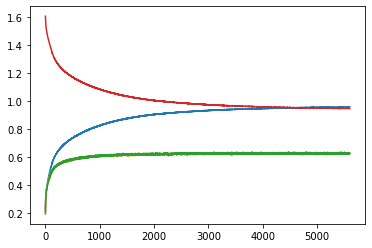

epoch: 0
train_acc: 0.958725
test_acc: 0.6253
f1: 0.6257962703775678

epoch: 1
train_acc: 0.95865
test_acc: 0.6279
f1: 0.6279036329011733

epoch: 2
train_acc: 0.959075
test_acc: 0.628
f1: 0.6282230757062305

epoch: 3
train_acc: 0.95855
test_acc: 0.6281
f1: 0.6288296190292821

epoch: 4
train_acc: 0.95845
test_acc: 0.624
f1: 0.6244392026805333

epoch: 5
train_acc: 0.95945
test_acc: 0.6304
f1: 0.6308827399204054

epoch: 6
train_acc: 0.95865
test_acc: 0.6222
f1: 0.6222144044891378

epoch: 7
train_acc: 0.958475
test_acc: 0.6221
f1: 0.6220173326036939

epoch: 8
train_acc: 0.958975
test_acc: 0.6264
f1: 0.626356585111527

epoch: 9
train_acc: 0.9587
test_acc: 0.6228
f1: 0.6237209412062361

epoch: 10
train_acc: 0.9591
test_acc: 0.6211
f1: 0.6222347569158161

epoch: 11
train_acc: 0.959175
test_acc: 0.6236
f1: 0.6248147638000611

epoch: 12
train_acc: 0.95825
test_acc: 0.6283
f1: 0.6290824436194807

epoch: 13
train_acc: 0.9583
test_acc: 0.626
f1: 0.6262789980712843

epoch: 14
train_acc: 0.95865
tes

epoch: 117
train_acc: 0.958775
test_acc: 0.6278
f1: 0.6279659841102144

epoch: 118
train_acc: 0.958775
test_acc: 0.6258
f1: 0.6262610222407751

epoch: 119
train_acc: 0.95855
test_acc: 0.6241
f1: 0.6244247693371624

epoch: 120
train_acc: 0.958125
test_acc: 0.6287
f1: 0.6290426034415753

epoch: 121
train_acc: 0.958625
test_acc: 0.6272
f1: 0.6281717261132599

epoch: 122
train_acc: 0.959275
test_acc: 0.6289
f1: 0.6296738496498873

epoch: 123
train_acc: 0.959375
test_acc: 0.6236
f1: 0.6239300245523001

epoch: 124
train_acc: 0.958675
test_acc: 0.6231
f1: 0.6229655840184851

epoch: 125
train_acc: 0.9598
test_acc: 0.63
f1: 0.6303131804147865

epoch: 126
train_acc: 0.958975
test_acc: 0.6259
f1: 0.6265452025755094

epoch: 127
train_acc: 0.959375
test_acc: 0.6257
f1: 0.6265894354204307

epoch: 128
train_acc: 0.959375
test_acc: 0.6252
f1: 0.6263520868760823

epoch: 129
train_acc: 0.959225
test_acc: 0.6252
f1: 0.6258005370849562

epoch: 130
train_acc: 0.960225
test_acc: 0.6226
f1: 0.622853162702838

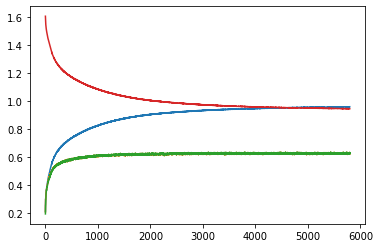

epoch: 0
train_acc: 0.96035
test_acc: 0.6264
f1: 0.6271550025365487

epoch: 1
train_acc: 0.95965
test_acc: 0.6211
f1: 0.6215991828065769

epoch: 2
train_acc: 0.96015
test_acc: 0.6194
f1: 0.6202828623544799

epoch: 3
train_acc: 0.960225
test_acc: 0.6189
f1: 0.6192500068408805

epoch: 4
train_acc: 0.959575
test_acc: 0.6276
f1: 0.6278508622242486

epoch: 5
train_acc: 0.95925
test_acc: 0.6295
f1: 0.6296008067276736

epoch: 6
train_acc: 0.96085
test_acc: 0.6256
f1: 0.6256660591098308

epoch: 7
train_acc: 0.96
test_acc: 0.6229
f1: 0.6233575074506773

epoch: 8
train_acc: 0.9594
test_acc: 0.6235
f1: 0.6236745351721805

epoch: 9
train_acc: 0.95925
test_acc: 0.6233
f1: 0.6233684010636831

epoch: 10
train_acc: 0.9596
test_acc: 0.626
f1: 0.6264475358332398

epoch: 11
train_acc: 0.95955
test_acc: 0.6282
f1: 0.627769560268474

epoch: 12
train_acc: 0.95995
test_acc: 0.6278
f1: 0.6278554809150891

epoch: 13
train_acc: 0.960125
test_acc: 0.6282
f1: 0.6281676217327993

epoch: 14
train_acc: 0.959675
test

epoch: 118
train_acc: 0.9598
test_acc: 0.6213
f1: 0.6214521028731408

epoch: 119
train_acc: 0.96025
test_acc: 0.6226
f1: 0.6229826535017639

epoch: 120
train_acc: 0.96005
test_acc: 0.6252
f1: 0.6262112762328494

epoch: 121
train_acc: 0.959425
test_acc: 0.6235
f1: 0.6241607601669978

epoch: 122
train_acc: 0.9606
test_acc: 0.6282
f1: 0.6283288752883676

epoch: 123
train_acc: 0.9594
test_acc: 0.6262
f1: 0.6261811833246808

epoch: 124
train_acc: 0.9604
test_acc: 0.6265
f1: 0.6265801716832214

epoch: 125
train_acc: 0.9599
test_acc: 0.6315
f1: 0.631952212934541

epoch: 126
train_acc: 0.9603
test_acc: 0.6242
f1: 0.6240820853168906

epoch: 127
train_acc: 0.96085
test_acc: 0.6209
f1: 0.621763989516466

epoch: 128
train_acc: 0.959925
test_acc: 0.6319
f1: 0.632144613207546

epoch: 129
train_acc: 0.960525
test_acc: 0.63
f1: 0.6301753042066598

epoch: 130
train_acc: 0.96005
test_acc: 0.6221
f1: 0.6218026303913319

epoch: 131
train_acc: 0.959675
test_acc: 0.6306
f1: 0.6304947607051451

epoch: 132
tr

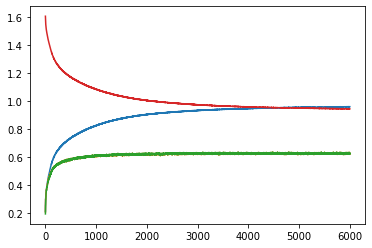

epoch: 0
train_acc: 0.96055
test_acc: 0.626
f1: 0.6266973168898684

epoch: 1
train_acc: 0.960925
test_acc: 0.6268
f1: 0.627286586643925

epoch: 2
train_acc: 0.960425
test_acc: 0.6208
f1: 0.6213786888174975

epoch: 3
train_acc: 0.960175
test_acc: 0.6209
f1: 0.6209053221985809

epoch: 4
train_acc: 0.9601
test_acc: 0.6255
f1: 0.6258759284174108

epoch: 5
train_acc: 0.959875
test_acc: 0.6276
f1: 0.6273272630815284

epoch: 6
train_acc: 0.96025
test_acc: 0.6307
f1: 0.63083347405869

epoch: 7
train_acc: 0.960325
test_acc: 0.6307
f1: 0.6312706460386189

epoch: 8
train_acc: 0.9607
test_acc: 0.6295
f1: 0.6299665082105236

epoch: 9
train_acc: 0.960225
test_acc: 0.6237
f1: 0.6246588623625275

epoch: 10
train_acc: 0.961
test_acc: 0.6331
f1: 0.6339944972391796

epoch: 11
train_acc: 0.96065
test_acc: 0.6247
f1: 0.6250852154532442

epoch: 12
train_acc: 0.959675
test_acc: 0.6245
f1: 0.6251292027600952

epoch: 13
train_acc: 0.96005
test_acc: 0.6246
f1: 0.6249904317705445

epoch: 14
train_acc: 0.960125
t

epoch: 118
train_acc: 0.96125
test_acc: 0.6216
f1: 0.6217425795938486

epoch: 119
train_acc: 0.960625
test_acc: 0.6316
f1: 0.6329257609869663

epoch: 120
train_acc: 0.961325
test_acc: 0.6248
f1: 0.6260120583874563

epoch: 121
train_acc: 0.960975
test_acc: 0.6218
f1: 0.6224008368432533

epoch: 122
train_acc: 0.9605
test_acc: 0.6277
f1: 0.628151472622695

epoch: 123
train_acc: 0.96035
test_acc: 0.6229
f1: 0.6230028059190181

epoch: 124
train_acc: 0.9613
test_acc: 0.6234
f1: 0.6236361869207284

epoch: 125
train_acc: 0.96115
test_acc: 0.6228
f1: 0.6229392838385645

epoch: 126
train_acc: 0.9604
test_acc: 0.6234
f1: 0.6234294175534928

epoch: 127
train_acc: 0.960875
test_acc: 0.6293
f1: 0.6293879501656917

epoch: 128
train_acc: 0.9609
test_acc: 0.6257
f1: 0.6258032482075168

epoch: 129
train_acc: 0.9609
test_acc: 0.6288
f1: 0.6289638171715538

epoch: 130
train_acc: 0.960675
test_acc: 0.6206
f1: 0.6213871130842966

epoch: 131
train_acc: 0.96115
test_acc: 0.6253
f1: 0.6256523108212444

epoch: 

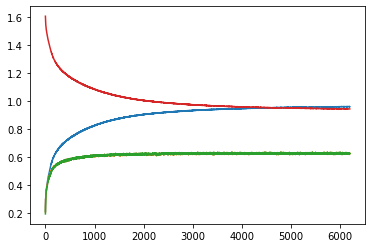

epoch: 0
train_acc: 0.961025
test_acc: 0.63
f1: 0.6302916179182932

epoch: 1
train_acc: 0.96095
test_acc: 0.6238
f1: 0.6236852735650138

epoch: 2
train_acc: 0.96125
test_acc: 0.6272
f1: 0.6275556283568297

epoch: 3
train_acc: 0.9616
test_acc: 0.6232
f1: 0.6241683325686356

epoch: 4
train_acc: 0.960725
test_acc: 0.629
f1: 0.6294858387304046

epoch: 5
train_acc: 0.96125
test_acc: 0.623
f1: 0.6236813819818515

epoch: 6
train_acc: 0.96105
test_acc: 0.6317
f1: 0.632196219069531

epoch: 7
train_acc: 0.96095
test_acc: 0.6166
f1: 0.6164265058973156

epoch: 8
train_acc: 0.961325
test_acc: 0.6252
f1: 0.6247436551311696

epoch: 9
train_acc: 0.961325
test_acc: 0.6257
f1: 0.6252210863758961

epoch: 10
train_acc: 0.9613
test_acc: 0.6281
f1: 0.6276734339171702

epoch: 11
train_acc: 0.961
test_acc: 0.6256
f1: 0.625847754495905

epoch: 12
train_acc: 0.961475
test_acc: 0.629
f1: 0.629067998056691

epoch: 13
train_acc: 0.961125
test_acc: 0.6254
f1: 0.6255542442522372

epoch: 14
train_acc: 0.96135
test_ac

epoch: 119
train_acc: 0.960925
test_acc: 0.6262
f1: 0.6260791443742805

epoch: 120
train_acc: 0.96185
test_acc: 0.6307
f1: 0.6310339800582689

epoch: 121
train_acc: 0.96185
test_acc: 0.6218
f1: 0.6221617167753578

epoch: 122
train_acc: 0.9607
test_acc: 0.6297
f1: 0.6299791387652969

epoch: 123
train_acc: 0.96145
test_acc: 0.6309
f1: 0.631140424558886

epoch: 124
train_acc: 0.961025
test_acc: 0.6289
f1: 0.6289451793901873

epoch: 125
train_acc: 0.961625
test_acc: 0.6279
f1: 0.6278427471820464

epoch: 126
train_acc: 0.961775
test_acc: 0.628
f1: 0.6282810408717814

epoch: 127
train_acc: 0.962225
test_acc: 0.629
f1: 0.6295879630020463

epoch: 128
train_acc: 0.9615
test_acc: 0.6299
f1: 0.6308274181569976

epoch: 129
train_acc: 0.961475
test_acc: 0.627
f1: 0.627345351543477

epoch: 130
train_acc: 0.961975
test_acc: 0.6266
f1: 0.6271538781147679

epoch: 131
train_acc: 0.961375
test_acc: 0.6313
f1: 0.6315929919522237

epoch: 132
train_acc: 0.96165
test_acc: 0.6254
f1: 0.6259874406856507

epoch

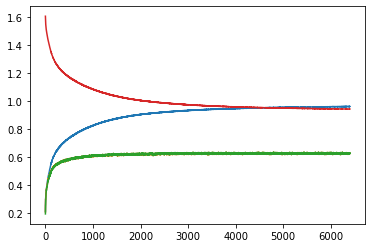

epoch: 0
train_acc: 0.9614
test_acc: 0.6298
f1: 0.6303295655651706

epoch: 1
train_acc: 0.962275
test_acc: 0.6288
f1: 0.6291804095933892

epoch: 2
train_acc: 0.961525
test_acc: 0.6251
f1: 0.625370947259303

epoch: 3
train_acc: 0.9624
test_acc: 0.6268
f1: 0.627466486604078

epoch: 4
train_acc: 0.961825
test_acc: 0.6196
f1: 0.6199775395442239

epoch: 5
train_acc: 0.962075
test_acc: 0.6259
f1: 0.6258670068553717

epoch: 6
train_acc: 0.9614
test_acc: 0.6282
f1: 0.6280690148801937

epoch: 7
train_acc: 0.9617
test_acc: 0.6269
f1: 0.6271342524482039

epoch: 8
train_acc: 0.961825
test_acc: 0.6241
f1: 0.623918810961305

epoch: 9
train_acc: 0.96145
test_acc: 0.6243
f1: 0.6246123534564232

epoch: 10
train_acc: 0.96155
test_acc: 0.6233
f1: 0.6233577816761103

epoch: 11
train_acc: 0.962025
test_acc: 0.6243
f1: 0.6242975545744133

epoch: 12
train_acc: 0.962375
test_acc: 0.6299
f1: 0.6295444824467726

epoch: 13
train_acc: 0.962325
test_acc: 0.6239
f1: 0.624729127503464

epoch: 14
train_acc: 0.9622
te

epoch: 118
train_acc: 0.9626
test_acc: 0.6271
f1: 0.6270788249624456

epoch: 119
train_acc: 0.9626
test_acc: 0.631
f1: 0.6308332177828019

epoch: 120
train_acc: 0.962125
test_acc: 0.6287
f1: 0.6283181327892293

epoch: 121
train_acc: 0.9626
test_acc: 0.6258
f1: 0.6257818501461131

epoch: 122
train_acc: 0.9626
test_acc: 0.6266
f1: 0.6267738963555856

epoch: 123
train_acc: 0.962425
test_acc: 0.6244
f1: 0.6249484693842464

epoch: 124
train_acc: 0.962625
test_acc: 0.6279
f1: 0.6282708558137678

epoch: 125
train_acc: 0.96335
test_acc: 0.625
f1: 0.6252711261067956

epoch: 126
train_acc: 0.963075
test_acc: 0.626
f1: 0.6261939964224775

epoch: 127
train_acc: 0.962475
test_acc: 0.6208
f1: 0.6209478105240896

epoch: 128
train_acc: 0.961925
test_acc: 0.6253
f1: 0.6251817699114708

epoch: 129
train_acc: 0.9622
test_acc: 0.6232
f1: 0.6229804206236

epoch: 130
train_acc: 0.9626
test_acc: 0.6252
f1: 0.6255265416775733

epoch: 131
train_acc: 0.963
test_acc: 0.6235
f1: 0.6238327207324361

epoch: 132
tra

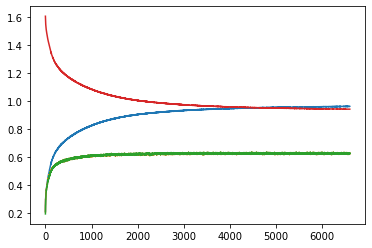

epoch: 0
train_acc: 0.963225
test_acc: 0.6281
f1: 0.6291897230473489

epoch: 1
train_acc: 0.962525
test_acc: 0.624
f1: 0.6253264130571881

epoch: 2
train_acc: 0.96305
test_acc: 0.6257
f1: 0.6264147770472617

epoch: 3
train_acc: 0.96295
test_acc: 0.6227
f1: 0.6227624970415914

epoch: 4
train_acc: 0.962925
test_acc: 0.6245
f1: 0.62390002016367

epoch: 5
train_acc: 0.962725
test_acc: 0.6181
f1: 0.617659143953991

epoch: 6
train_acc: 0.96215
test_acc: 0.6264
f1: 0.6261980913159471

epoch: 7
train_acc: 0.962525
test_acc: 0.6226
f1: 0.622878790536333

epoch: 8
train_acc: 0.9627
test_acc: 0.6226
f1: 0.6231848712133056

epoch: 9
train_acc: 0.9634
test_acc: 0.6198
f1: 0.6203935902663248

epoch: 10
train_acc: 0.9627
test_acc: 0.6266
f1: 0.626526380954584

epoch: 11
train_acc: 0.96305
test_acc: 0.6248
f1: 0.6245359135327652

epoch: 12
train_acc: 0.9626
test_acc: 0.6248
f1: 0.6245766564571144

epoch: 13
train_acc: 0.962925
test_acc: 0.6238
f1: 0.6237366640458466

epoch: 14
train_acc: 0.9627
test_a

epoch: 118
train_acc: 0.962925
test_acc: 0.6243
f1: 0.6249372034183687

epoch: 119
train_acc: 0.963825
test_acc: 0.6235
f1: 0.6240818031411985

epoch: 120
train_acc: 0.9636
test_acc: 0.6241
f1: 0.6239908314873475

epoch: 121
train_acc: 0.963175
test_acc: 0.6263
f1: 0.6256052014419359

epoch: 122
train_acc: 0.963075
test_acc: 0.627
f1: 0.626099573820873

epoch: 123
train_acc: 0.96295
test_acc: 0.6223
f1: 0.6220091230455462

epoch: 124
train_acc: 0.9629
test_acc: 0.6262
f1: 0.6262796004170965

epoch: 125
train_acc: 0.963525
test_acc: 0.6233
f1: 0.6240089091864289

epoch: 126
train_acc: 0.962925
test_acc: 0.622
f1: 0.623084801297154

epoch: 127
train_acc: 0.9636
test_acc: 0.627
f1: 0.6273060264022139

epoch: 128
train_acc: 0.96335
test_acc: 0.6257
f1: 0.6250128287492631

epoch: 129
train_acc: 0.962875
test_acc: 0.6242
f1: 0.6233266800305111

epoch: 130
train_acc: 0.96365
test_acc: 0.6259
f1: 0.6253805993127604

epoch: 131
train_acc: 0.963275
test_acc: 0.6283
f1: 0.6275483258833193

epoch:

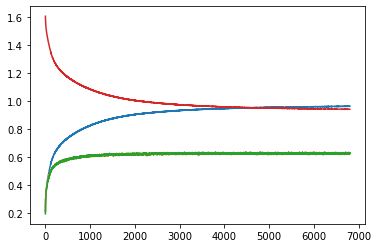

epoch: 0
train_acc: 0.96355
test_acc: 0.6264
f1: 0.6264774752276702

epoch: 1
train_acc: 0.96395
test_acc: 0.6236
f1: 0.6239693471095841

epoch: 2
train_acc: 0.963175
test_acc: 0.6263
f1: 0.6267114764220275

epoch: 3
train_acc: 0.9637
test_acc: 0.6245
f1: 0.6249830087019629

epoch: 4
train_acc: 0.963075
test_acc: 0.6219
f1: 0.6222910425987986

epoch: 5
train_acc: 0.9642
test_acc: 0.6192
f1: 0.6199385136946602

epoch: 6
train_acc: 0.9636
test_acc: 0.6221
f1: 0.6221424420861433

epoch: 7
train_acc: 0.963225
test_acc: 0.6245
f1: 0.6251406476037376

epoch: 8
train_acc: 0.963875
test_acc: 0.6264
f1: 0.6259640724772507

epoch: 9
train_acc: 0.963175
test_acc: 0.6293
f1: 0.6295530272067225

epoch: 10
train_acc: 0.963375
test_acc: 0.6283
f1: 0.6284987261176542

epoch: 11
train_acc: 0.963075
test_acc: 0.6273
f1: 0.6271392875531786

epoch: 12
train_acc: 0.9641
test_acc: 0.6232
f1: 0.6233381901563582

epoch: 13
train_acc: 0.9636
test_acc: 0.6295
f1: 0.629742088630188

epoch: 14
train_acc: 0.9634
t

epoch: 118
train_acc: 0.9635
test_acc: 0.6246
f1: 0.624427977289184

epoch: 119
train_acc: 0.964
test_acc: 0.6208
f1: 0.6215765556795186

epoch: 120
train_acc: 0.9639
test_acc: 0.6257
f1: 0.6259482429200152

epoch: 121
train_acc: 0.964525
test_acc: 0.6204
f1: 0.6203770660510257

epoch: 122
train_acc: 0.964075
test_acc: 0.631
f1: 0.6311686965480064

epoch: 123
train_acc: 0.96445
test_acc: 0.6267
f1: 0.6268829477551655

epoch: 124
train_acc: 0.96435
test_acc: 0.6283
f1: 0.6281010996966172

epoch: 125
train_acc: 0.96455
test_acc: 0.6254
f1: 0.6257088848382376

epoch: 126
train_acc: 0.963975
test_acc: 0.6328
f1: 0.63306033414422

epoch: 127
train_acc: 0.96375
test_acc: 0.6254
f1: 0.6254927137376621

epoch: 128
train_acc: 0.963825
test_acc: 0.6282
f1: 0.6278620820995707

epoch: 129
train_acc: 0.9646
test_acc: 0.6255
f1: 0.6254096499216397

epoch: 130
train_acc: 0.963425
test_acc: 0.6253
f1: 0.6255926558486077

epoch: 131
train_acc: 0.9639
test_acc: 0.627
f1: 0.6269264848864815

epoch: 132
t

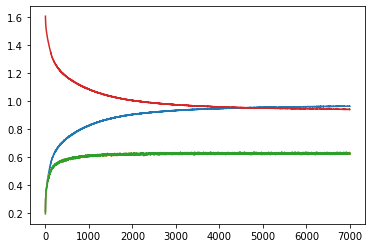

epoch: 0
train_acc: 0.96375
test_acc: 0.6261
f1: 0.6260023124126337

epoch: 1
train_acc: 0.964525
test_acc: 0.6299
f1: 0.6292905106163169

epoch: 2
train_acc: 0.964375
test_acc: 0.6251
f1: 0.6245694923281104

epoch: 3
train_acc: 0.96355
test_acc: 0.629
f1: 0.6289075547097607

epoch: 4
train_acc: 0.96445
test_acc: 0.6246
f1: 0.6250471416036836

epoch: 5
train_acc: 0.965125
test_acc: 0.6294
f1: 0.6297871741093759

epoch: 6
train_acc: 0.9648
test_acc: 0.6285
f1: 0.6290360108043255

epoch: 7
train_acc: 0.9654
test_acc: 0.6319
f1: 0.6324880679232854

epoch: 8
train_acc: 0.96445
test_acc: 0.6293
f1: 0.6294775081797916

epoch: 9
train_acc: 0.964725
test_acc: 0.6265
f1: 0.6266968367794583

epoch: 10
train_acc: 0.964375
test_acc: 0.6234
f1: 0.6238701145531825

epoch: 11
train_acc: 0.964625
test_acc: 0.6284
f1: 0.6289536980041581

epoch: 12
train_acc: 0.965025
test_acc: 0.626
f1: 0.6260768038443779

epoch: 13
train_acc: 0.964875
test_acc: 0.6302
f1: 0.6304896303469989

epoch: 14
train_acc: 0.964

epoch: 118
train_acc: 0.965375
test_acc: 0.6268
f1: 0.6271394074410084

epoch: 119
train_acc: 0.9653
test_acc: 0.6267
f1: 0.6272176986574366

epoch: 120
train_acc: 0.96555
test_acc: 0.6266
f1: 0.6269808866592856

epoch: 121
train_acc: 0.965125
test_acc: 0.6299
f1: 0.6302617644249952

epoch: 122
train_acc: 0.964825
test_acc: 0.623
f1: 0.6233843328106384

epoch: 123
train_acc: 0.9646
test_acc: 0.6316
f1: 0.6319968874948251

epoch: 124
train_acc: 0.96515
test_acc: 0.6215
f1: 0.6219733892206039

epoch: 125
train_acc: 0.964525
test_acc: 0.6205
f1: 0.6211678816296491

epoch: 126
train_acc: 0.964525
test_acc: 0.6244
f1: 0.6244564154814002

epoch: 127
train_acc: 0.964675
test_acc: 0.6233
f1: 0.6233609677443087

epoch: 128
train_acc: 0.965225
test_acc: 0.6249
f1: 0.6249481885719055

epoch: 129
train_acc: 0.964825
test_acc: 0.6319
f1: 0.6319272480585447

epoch: 130
train_acc: 0.9651
test_acc: 0.621
f1: 0.6216477429662802

epoch: 131
train_acc: 0.964375
test_acc: 0.6294
f1: 0.6299065829805961

ep

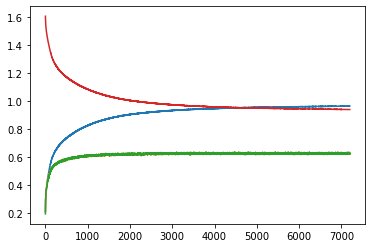

epoch: 0
train_acc: 0.9649
test_acc: 0.6305
f1: 0.63124213946518

epoch: 1
train_acc: 0.965575
test_acc: 0.6247
f1: 0.6249367607606314

epoch: 2
train_acc: 0.965325
test_acc: 0.6238
f1: 0.6242532230625142

epoch: 3
train_acc: 0.965525
test_acc: 0.6266
f1: 0.6269444455531394

epoch: 4
train_acc: 0.964975
test_acc: 0.6214
f1: 0.6212024820637408

epoch: 5
train_acc: 0.9645
test_acc: 0.6261
f1: 0.6255434128505768

epoch: 6
train_acc: 0.96535
test_acc: 0.6248
f1: 0.6248848470169033

epoch: 7
train_acc: 0.964875
test_acc: 0.6232
f1: 0.6232878682468929

epoch: 8
train_acc: 0.96535
test_acc: 0.6251
f1: 0.6250908425052916

epoch: 9
train_acc: 0.9648
test_acc: 0.6214
f1: 0.6213986828270146

epoch: 10
train_acc: 0.96485
test_acc: 0.6221
f1: 0.6225463391995424

epoch: 11
train_acc: 0.965025
test_acc: 0.6244
f1: 0.6244032418665433

epoch: 12
train_acc: 0.96535
test_acc: 0.6256
f1: 0.6254592190267922

epoch: 13
train_acc: 0.9657
test_acc: 0.6287
f1: 0.6283569622845125

epoch: 14
train_acc: 0.96515
t

epoch: 118
train_acc: 0.965575
test_acc: 0.6235
f1: 0.6228411703149259

epoch: 119
train_acc: 0.965725
test_acc: 0.6248
f1: 0.6249507853759

epoch: 120
train_acc: 0.9659
test_acc: 0.6341
f1: 0.6340365816676116

epoch: 121
train_acc: 0.965425
test_acc: 0.6252
f1: 0.6253935763454902

epoch: 122
train_acc: 0.96585
test_acc: 0.6284
f1: 0.628374611198378

epoch: 123
train_acc: 0.965575
test_acc: 0.6252
f1: 0.6257095182649435

epoch: 124
train_acc: 0.966225
test_acc: 0.6231
f1: 0.623553526672855

epoch: 125
train_acc: 0.9657
test_acc: 0.6261
f1: 0.6266972896941726

epoch: 126
train_acc: 0.965825
test_acc: 0.626
f1: 0.6263540283041586

epoch: 127
train_acc: 0.965625
test_acc: 0.6318
f1: 0.6322945232744079

epoch: 128
train_acc: 0.966025
test_acc: 0.6271
f1: 0.6273100615018274

epoch: 129
train_acc: 0.964725
test_acc: 0.6224
f1: 0.6224653457991068

epoch: 130
train_acc: 0.96505
test_acc: 0.6284
f1: 0.6288043061381291

epoch: 131
train_acc: 0.9663
test_acc: 0.6257
f1: 0.6262831867043709

epoch:

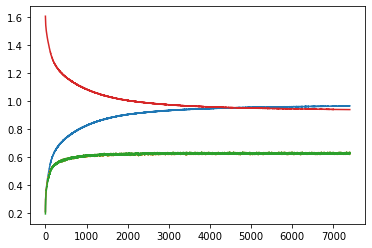

epoch: 0
train_acc: 0.9652
test_acc: 0.6216
f1: 0.6215406250765714

epoch: 1
train_acc: 0.966075
test_acc: 0.6321
f1: 0.6319981998750588

epoch: 2
train_acc: 0.96605
test_acc: 0.6308
f1: 0.6305878564908374

epoch: 3
train_acc: 0.965325
test_acc: 0.6232
f1: 0.6231804069035476

epoch: 4
train_acc: 0.965825
test_acc: 0.6233
f1: 0.6236676493732349

epoch: 5
train_acc: 0.9653
test_acc: 0.6277
f1: 0.628379583341193

epoch: 6
train_acc: 0.96525
test_acc: 0.6224
f1: 0.6230813751086893

epoch: 7
train_acc: 0.966175
test_acc: 0.6285
f1: 0.6288849742434862

epoch: 8
train_acc: 0.966475
test_acc: 0.6218
f1: 0.6214681282061457

epoch: 9
train_acc: 0.9651
test_acc: 0.6247
f1: 0.6247288987370392

epoch: 10
train_acc: 0.965675
test_acc: 0.6229
f1: 0.6227364704131266

epoch: 11
train_acc: 0.9655
test_acc: 0.6243
f1: 0.6241427869244739

epoch: 12
train_acc: 0.965775
test_acc: 0.623
f1: 0.6226095802969265

epoch: 13
train_acc: 0.96545
test_acc: 0.6242
f1: 0.6242133751251611

epoch: 14
train_acc: 0.9657
t

epoch: 118
train_acc: 0.965425
test_acc: 0.6272
f1: 0.6270906425182349

epoch: 119
train_acc: 0.966175
test_acc: 0.6228
f1: 0.6222493025753775

epoch: 120
train_acc: 0.966325
test_acc: 0.6298
f1: 0.6293288214961229

epoch: 121
train_acc: 0.965725
test_acc: 0.6278
f1: 0.627299587221442

epoch: 122
train_acc: 0.965275
test_acc: 0.6258
f1: 0.6253791585473567

epoch: 123
train_acc: 0.966175
test_acc: 0.6275
f1: 0.6278371968506671

epoch: 124
train_acc: 0.966025
test_acc: 0.6257
f1: 0.6259570326362914

epoch: 125
train_acc: 0.9656
test_acc: 0.6236
f1: 0.6243682092266502

epoch: 126
train_acc: 0.965725
test_acc: 0.6296
f1: 0.630094576065526

epoch: 127
train_acc: 0.965975
test_acc: 0.6272
f1: 0.6277369842083723

epoch: 128
train_acc: 0.966425
test_acc: 0.6314
f1: 0.6309097774844211

epoch: 129
train_acc: 0.965725
test_acc: 0.6269
f1: 0.6263054053188359

epoch: 130
train_acc: 0.96605
test_acc: 0.6255
f1: 0.6254882844689984

epoch: 131
train_acc: 0.966575
test_acc: 0.6232
f1: 0.622643976466784

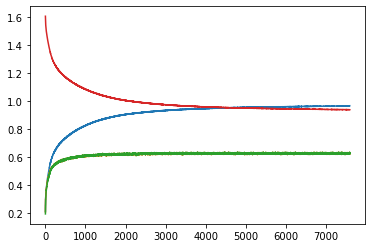

epoch: 0
train_acc: 0.966575
test_acc: 0.6297
f1: 0.6298657599204106

epoch: 1
train_acc: 0.965925
test_acc: 0.6289
f1: 0.6290860820549424

epoch: 2
train_acc: 0.9664
test_acc: 0.6237
f1: 0.6239746803887171

epoch: 3
train_acc: 0.966275
test_acc: 0.6282
f1: 0.6283701208616604

epoch: 4
train_acc: 0.9659
test_acc: 0.6292
f1: 0.6292629999497366

epoch: 5
train_acc: 0.96595
test_acc: 0.621
f1: 0.6211023372058809

epoch: 6
train_acc: 0.9659
test_acc: 0.6239
f1: 0.6242247008843077

epoch: 7
train_acc: 0.966775
test_acc: 0.6205
f1: 0.6203745359286454

epoch: 8
train_acc: 0.96685
test_acc: 0.6244
f1: 0.6245186748279865

epoch: 9
train_acc: 0.9664
test_acc: 0.6286
f1: 0.6284005516437585

epoch: 10
train_acc: 0.9663
test_acc: 0.628
f1: 0.6276493826911829

epoch: 11
train_acc: 0.9667
test_acc: 0.6234
f1: 0.6237315384392065

epoch: 12
train_acc: 0.9666
test_acc: 0.6208
f1: 0.6209161306444224

epoch: 13
train_acc: 0.96705
test_acc: 0.6293
f1: 0.6301857960935893

epoch: 14
train_acc: 0.96635
test_a

epoch: 118
train_acc: 0.966575
test_acc: 0.6233
f1: 0.623828009472868

epoch: 119
train_acc: 0.9668
test_acc: 0.6239
f1: 0.6246939670390984

epoch: 120
train_acc: 0.96635
test_acc: 0.621
f1: 0.6212376524172739

epoch: 121
train_acc: 0.966875
test_acc: 0.6238
f1: 0.6233994126706479

epoch: 122
train_acc: 0.9669
test_acc: 0.6225
f1: 0.6217874319679179

epoch: 123
train_acc: 0.966575
test_acc: 0.6242
f1: 0.6237812173308075

epoch: 124
train_acc: 0.96705
test_acc: 0.6269
f1: 0.6274093757120629

epoch: 125
train_acc: 0.966575
test_acc: 0.6247
f1: 0.6257617329567337

epoch: 126
train_acc: 0.966225
test_acc: 0.6288
f1: 0.6295022435243417

epoch: 127
train_acc: 0.967125
test_acc: 0.6261
f1: 0.6265407952613009

epoch: 128
train_acc: 0.966525
test_acc: 0.6222
f1: 0.6217876608329707

epoch: 129
train_acc: 0.966475
test_acc: 0.624
f1: 0.6234883622344124

epoch: 130
train_acc: 0.966225
test_acc: 0.6221
f1: 0.6213352766892932

epoch: 131
train_acc: 0.966925
test_acc: 0.6261
f1: 0.6260993204040904

e

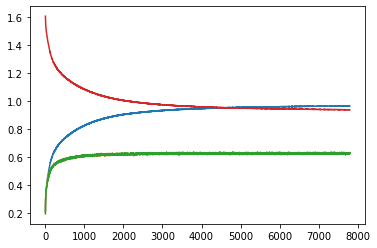

epoch: 0
train_acc: 0.966725
test_acc: 0.6198
f1: 0.6205823003034893

epoch: 1
train_acc: 0.96645
test_acc: 0.6229
f1: 0.6223808470516642

epoch: 2
train_acc: 0.966625
test_acc: 0.6238
f1: 0.6227236806065274

epoch: 3
train_acc: 0.96615
test_acc: 0.6243
f1: 0.6240281783039493

epoch: 4
train_acc: 0.96685
test_acc: 0.6257
f1: 0.6256981755591778

epoch: 5
train_acc: 0.966875
test_acc: 0.6261
f1: 0.6263223589681883

epoch: 6
train_acc: 0.9672
test_acc: 0.623
f1: 0.6240105393237425

epoch: 7
train_acc: 0.966925
test_acc: 0.6262
f1: 0.6266852113577831

epoch: 8
train_acc: 0.966575
test_acc: 0.6236
f1: 0.6234811605903965

epoch: 9
train_acc: 0.966475
test_acc: 0.6274
f1: 0.6269284425692757

epoch: 10
train_acc: 0.967225
test_acc: 0.625
f1: 0.6245758766957006

epoch: 11
train_acc: 0.96695
test_acc: 0.6261
f1: 0.6264210601155609

epoch: 12
train_acc: 0.967325
test_acc: 0.623
f1: 0.6229564049566674

epoch: 13
train_acc: 0.96735
test_acc: 0.6208
f1: 0.6213428018362235

epoch: 14
train_acc: 0.966

epoch: 118
train_acc: 0.96665
test_acc: 0.6317
f1: 0.6314737069571682

epoch: 119
train_acc: 0.9672
test_acc: 0.6283
f1: 0.6280670167629693

epoch: 120
train_acc: 0.9675
test_acc: 0.625
f1: 0.6253431356699004

epoch: 121
train_acc: 0.966675
test_acc: 0.6237
f1: 0.6241759334292332

epoch: 122
train_acc: 0.967225
test_acc: 0.6216
f1: 0.622128356250016

epoch: 123
train_acc: 0.967525
test_acc: 0.628
f1: 0.6287712367787314

epoch: 124
train_acc: 0.967525
test_acc: 0.6265
f1: 0.6262885585719253

epoch: 125
train_acc: 0.96715
test_acc: 0.6268
f1: 0.6268533565489129

epoch: 126
train_acc: 0.967025
test_acc: 0.6284
f1: 0.6283027742305831

epoch: 127
train_acc: 0.966625
test_acc: 0.6306
f1: 0.631138171051393

epoch: 128
train_acc: 0.96765
test_acc: 0.6243
f1: 0.625105145035158

epoch: 129
train_acc: 0.96725
test_acc: 0.6258
f1: 0.626273449472163

epoch: 130
train_acc: 0.967525
test_acc: 0.6235
f1: 0.6239501828749928

epoch: 131
train_acc: 0.967275
test_acc: 0.623
f1: 0.6232681081617885

epoch: 

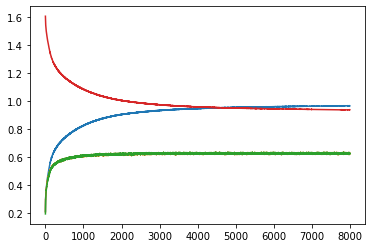

epoch: 0
train_acc: 0.9673
test_acc: 0.6193
f1: 0.6198373215055959

epoch: 1
train_acc: 0.967075
test_acc: 0.6246
f1: 0.6242738105020859

epoch: 2
train_acc: 0.967725
test_acc: 0.6236
f1: 0.6237055978388418

epoch: 3
train_acc: 0.966825
test_acc: 0.6242
f1: 0.6247819893026079

epoch: 4
train_acc: 0.967275
test_acc: 0.6248
f1: 0.6256291724783303

epoch: 5
train_acc: 0.967725
test_acc: 0.6248
f1: 0.6253317099656016

epoch: 6
train_acc: 0.966825
test_acc: 0.6262
f1: 0.6268537495604307

epoch: 7
train_acc: 0.9672
test_acc: 0.6258
f1: 0.6261314372395899

epoch: 8
train_acc: 0.96755
test_acc: 0.6238
f1: 0.6237374063663692

epoch: 9
train_acc: 0.96725
test_acc: 0.618
f1: 0.6176978039632198

epoch: 10
train_acc: 0.96745
test_acc: 0.6255
f1: 0.6252321617702586

epoch: 11
train_acc: 0.968225
test_acc: 0.6207
f1: 0.6212442417205953

epoch: 12
train_acc: 0.967575
test_acc: 0.6242
f1: 0.624992719114856

epoch: 13
train_acc: 0.96795
test_acc: 0.6226
f1: 0.6226525332049522

epoch: 14
train_acc: 0.967

epoch: 118
train_acc: 0.967625
test_acc: 0.6246
f1: 0.6248983022155206

epoch: 119
train_acc: 0.96845
test_acc: 0.6254
f1: 0.6256134761303972

epoch: 120
train_acc: 0.968125
test_acc: 0.6261
f1: 0.6265249682182316

epoch: 121
train_acc: 0.967025
test_acc: 0.628
f1: 0.6286016481894237

epoch: 122
train_acc: 0.9681
test_acc: 0.6232
f1: 0.6231739650284066

epoch: 123
train_acc: 0.968375
test_acc: 0.6253
f1: 0.6252731326001599

epoch: 124
train_acc: 0.96765
test_acc: 0.6288
f1: 0.6287052711851354

epoch: 125
train_acc: 0.96765
test_acc: 0.623
f1: 0.6230661374013775

epoch: 126
train_acc: 0.968225
test_acc: 0.6241
f1: 0.6245512608138802

epoch: 127
train_acc: 0.9682
test_acc: 0.6323
f1: 0.6325893046162618

epoch: 128
train_acc: 0.967425
test_acc: 0.6253
f1: 0.6253990790086602

epoch: 129
train_acc: 0.9677
test_acc: 0.6248
f1: 0.6245205705014845

epoch: 130
train_acc: 0.967375
test_acc: 0.6223
f1: 0.6219536834469279

epoch: 131
train_acc: 0.96815
test_acc: 0.6266
f1: 0.6261204036363442

epoc

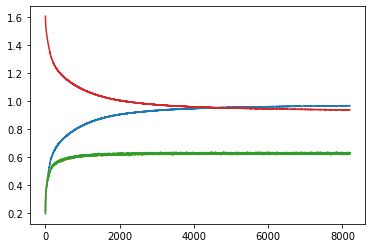

epoch: 0
train_acc: 0.96735
test_acc: 0.6235
f1: 0.622713738958454

epoch: 1
train_acc: 0.96795
test_acc: 0.6255
f1: 0.6251650478622921

epoch: 2
train_acc: 0.967825
test_acc: 0.6259
f1: 0.6256138506796844

epoch: 3
train_acc: 0.9679
test_acc: 0.6323
f1: 0.6321273902821541

epoch: 4
train_acc: 0.967725
test_acc: 0.6254
f1: 0.6257144429403892

epoch: 5
train_acc: 0.967475
test_acc: 0.6289
f1: 0.628912586239751

epoch: 6
train_acc: 0.96715
test_acc: 0.6248
f1: 0.6247087583449907

epoch: 7
train_acc: 0.96765
test_acc: 0.6273
f1: 0.6277103161759751

epoch: 8
train_acc: 0.967825
test_acc: 0.6254
f1: 0.624731958626942

epoch: 9
train_acc: 0.967275
test_acc: 0.6251
f1: 0.6248159677908958

epoch: 10
train_acc: 0.968375
test_acc: 0.6279
f1: 0.6279053317804132

epoch: 11
train_acc: 0.968175
test_acc: 0.6277
f1: 0.6280505149446979

epoch: 12
train_acc: 0.9678
test_acc: 0.6262
f1: 0.6267889079830841

epoch: 13
train_acc: 0.9682
test_acc: 0.6293
f1: 0.6297176551493802

epoch: 14
train_acc: 0.9674
t

epoch: 117
train_acc: 0.967425
test_acc: 0.6243
f1: 0.6246917457332503

epoch: 118
train_acc: 0.968175
test_acc: 0.628
f1: 0.6281156492905002

epoch: 119
train_acc: 0.968025
test_acc: 0.6244
f1: 0.6242030451353685

epoch: 120
train_acc: 0.96805
test_acc: 0.6303
f1: 0.6307163094328058

epoch: 121
train_acc: 0.96845
test_acc: 0.6305
f1: 0.6308172379139166

epoch: 122
train_acc: 0.96835
test_acc: 0.6254
f1: 0.625968026156619

epoch: 123
train_acc: 0.967975
test_acc: 0.6235
f1: 0.6236568489095231

epoch: 124
train_acc: 0.96815
test_acc: 0.6241
f1: 0.6247939097171477

epoch: 125
train_acc: 0.967975
test_acc: 0.6273
f1: 0.6275829923118535

epoch: 126
train_acc: 0.96785
test_acc: 0.6237
f1: 0.6236105672465525

epoch: 127
train_acc: 0.96795
test_acc: 0.6261
f1: 0.6257361862082639

epoch: 128
train_acc: 0.968225
test_acc: 0.6243
f1: 0.6243422348811857

epoch: 129
train_acc: 0.968025
test_acc: 0.6291
f1: 0.6293153472248622

epoch: 130
train_acc: 0.96745
test_acc: 0.6267
f1: 0.6268794841491632

e

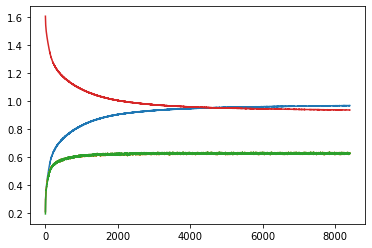

epoch: 0
train_acc: 0.968525
test_acc: 0.6225
f1: 0.6225706597268436

epoch: 1
train_acc: 0.9686
test_acc: 0.6222
f1: 0.6223821409676269

epoch: 2
train_acc: 0.9679
test_acc: 0.6275
f1: 0.6281249493231638

epoch: 3
train_acc: 0.9681
test_acc: 0.6203
f1: 0.6211173668149913

epoch: 4
train_acc: 0.9685
test_acc: 0.6216
f1: 0.6223451789415924

epoch: 5
train_acc: 0.96795
test_acc: 0.6266
f1: 0.6268955926510964

epoch: 6
train_acc: 0.967925
test_acc: 0.6266
f1: 0.6265144410096484

epoch: 7
train_acc: 0.968375
test_acc: 0.6326
f1: 0.6320784040504479

epoch: 8
train_acc: 0.968575
test_acc: 0.6288
f1: 0.6281009129911699

epoch: 9
train_acc: 0.9684
test_acc: 0.6252
f1: 0.6246752036031172

epoch: 10
train_acc: 0.967925
test_acc: 0.6272
f1: 0.6272770231658776

epoch: 11
train_acc: 0.96815
test_acc: 0.6259
f1: 0.6263910739697621

epoch: 12
train_acc: 0.96855
test_acc: 0.6234
f1: 0.6241789474896665

epoch: 13
train_acc: 0.967825
test_acc: 0.6239
f1: 0.6239924467079181

epoch: 14
train_acc: 0.968075

epoch: 118
train_acc: 0.967875
test_acc: 0.6282
f1: 0.6278102133186176

epoch: 119
train_acc: 0.969
test_acc: 0.6219
f1: 0.6220760494610288

epoch: 120
train_acc: 0.9684
test_acc: 0.6273
f1: 0.6276898920694375

epoch: 121
train_acc: 0.96865
test_acc: 0.627
f1: 0.6276560427981742

epoch: 122
train_acc: 0.968125
test_acc: 0.6239
f1: 0.6242643442958282

epoch: 123
train_acc: 0.968825
test_acc: 0.6207
f1: 0.6210089860698047

epoch: 124
train_acc: 0.9688
test_acc: 0.6249
f1: 0.6244747262835383

epoch: 125
train_acc: 0.9685
test_acc: 0.6258
f1: 0.6257024770657735

epoch: 126
train_acc: 0.96805
test_acc: 0.6198
f1: 0.6200378551623704

epoch: 127
train_acc: 0.968675
test_acc: 0.6196
f1: 0.6199597569814604

epoch: 128
train_acc: 0.9682
test_acc: 0.6211
f1: 0.6210232835936597

epoch: 129
train_acc: 0.968575
test_acc: 0.6283
f1: 0.6281344769439251

epoch: 130
train_acc: 0.9679
test_acc: 0.63
f1: 0.6297328854155927

epoch: 131
train_acc: 0.96865
test_acc: 0.6227
f1: 0.6226426398750811

epoch: 132


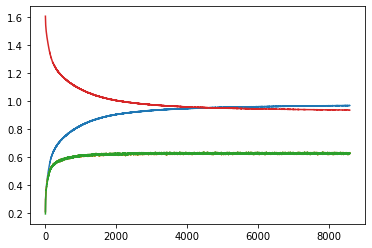

epoch: 0
train_acc: 0.9686
test_acc: 0.6275
f1: 0.6275429469801606

epoch: 1
train_acc: 0.968375
test_acc: 0.6243
f1: 0.6239415396856902

epoch: 2
train_acc: 0.968425
test_acc: 0.6214
f1: 0.6214410034020853

epoch: 3
train_acc: 0.96925
test_acc: 0.6264
f1: 0.6263852582508196

epoch: 4
train_acc: 0.968825
test_acc: 0.6222
f1: 0.6223133686841096

epoch: 5
train_acc: 0.968975
test_acc: 0.6257
f1: 0.6257142071427408

epoch: 6
train_acc: 0.96875
test_acc: 0.6279
f1: 0.6279270792184889

epoch: 7
train_acc: 0.9688
test_acc: 0.6278
f1: 0.6282627357337282

epoch: 8
train_acc: 0.96825
test_acc: 0.6249
f1: 0.6258203895724688

epoch: 9
train_acc: 0.96815
test_acc: 0.6249
f1: 0.6258488430986301

epoch: 10
train_acc: 0.968825
test_acc: 0.6292
f1: 0.6295042208752059

epoch: 11
train_acc: 0.968575
test_acc: 0.6256
f1: 0.6254750824458988

epoch: 12
train_acc: 0.96865
test_acc: 0.6243
f1: 0.6237036794908601

epoch: 13
train_acc: 0.968375
test_acc: 0.6251
f1: 0.6239366437951537

epoch: 14
train_acc: 0.96

epoch: 118
train_acc: 0.96895
test_acc: 0.6216
f1: 0.6215827661588295

epoch: 119
train_acc: 0.9692
test_acc: 0.6257
f1: 0.6261015923075088

epoch: 120
train_acc: 0.969275
test_acc: 0.626
f1: 0.6261552038932724

epoch: 121
train_acc: 0.9687
test_acc: 0.6223
f1: 0.6223576589886656

epoch: 122
train_acc: 0.968775
test_acc: 0.6262
f1: 0.6267011136827335

epoch: 123
train_acc: 0.968425
test_acc: 0.6278
f1: 0.6279664880287119

epoch: 124
train_acc: 0.968575
test_acc: 0.6283
f1: 0.6280158874500236

epoch: 125
train_acc: 0.9685
test_acc: 0.6237
f1: 0.6231718121526084

epoch: 126
train_acc: 0.9689
test_acc: 0.6336
f1: 0.6332661492306467

epoch: 127
train_acc: 0.969425
test_acc: 0.622
f1: 0.6219295831354075

epoch: 128
train_acc: 0.968675
test_acc: 0.6252
f1: 0.625257094890967

epoch: 129
train_acc: 0.968875
test_acc: 0.6289
f1: 0.628769937521609

epoch: 130
train_acc: 0.968875
test_acc: 0.6262
f1: 0.6266967452165302

epoch: 131
train_acc: 0.9686
test_acc: 0.6267
f1: 0.6273257492048133

epoch: 

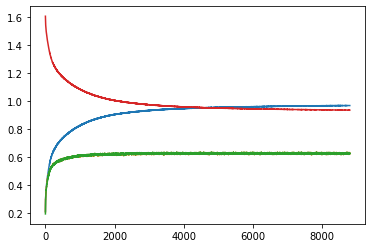

epoch: 0
train_acc: 0.968925
test_acc: 0.6296
f1: 0.6293451369005167

epoch: 1
train_acc: 0.969075
test_acc: 0.6223
f1: 0.6219969771678878

epoch: 2
train_acc: 0.968675
test_acc: 0.6267
f1: 0.6271085884048585

epoch: 3
train_acc: 0.96895
test_acc: 0.6264
f1: 0.627071290485532

epoch: 4
train_acc: 0.96945
test_acc: 0.6282
f1: 0.6285446332427755

epoch: 5
train_acc: 0.9686
test_acc: 0.6274
f1: 0.6272932257433023

epoch: 6
train_acc: 0.968475
test_acc: 0.6219
f1: 0.6216807457244148

epoch: 7
train_acc: 0.9686
test_acc: 0.6305
f1: 0.6304739786149425

epoch: 8
train_acc: 0.969275
test_acc: 0.6282
f1: 0.6282648361745887

epoch: 9
train_acc: 0.96915
test_acc: 0.6261
f1: 0.6261124694407304

epoch: 10
train_acc: 0.968625
test_acc: 0.6273
f1: 0.6274731031437728

epoch: 11
train_acc: 0.96925
test_acc: 0.628
f1: 0.6286815053152243

epoch: 12
train_acc: 0.96845
test_acc: 0.6265
f1: 0.6267847468902703

epoch: 13
train_acc: 0.96965
test_acc: 0.6209
f1: 0.6211461446645772

epoch: 14
train_acc: 0.96905

epoch: 117
train_acc: 0.969225
test_acc: 0.6271
f1: 0.6270760080799177

epoch: 118
train_acc: 0.9693
test_acc: 0.626
f1: 0.6262054213973236

epoch: 119
train_acc: 0.96905
test_acc: 0.6259
f1: 0.6262639322213666

epoch: 120
train_acc: 0.96905
test_acc: 0.6218
f1: 0.621232666744796

epoch: 121
train_acc: 0.968925
test_acc: 0.6241
f1: 0.6240773765199343

epoch: 122
train_acc: 0.969575
test_acc: 0.624
f1: 0.6234709037971704

epoch: 123
train_acc: 0.969475
test_acc: 0.6208
f1: 0.6205815128674979

epoch: 124
train_acc: 0.969475
test_acc: 0.6225
f1: 0.6225036728166192

epoch: 125
train_acc: 0.969225
test_acc: 0.6205
f1: 0.6205294268122856

epoch: 126
train_acc: 0.96885
test_acc: 0.6243
f1: 0.6242285277651394

epoch: 127
train_acc: 0.96905
test_acc: 0.6249
f1: 0.6250055390828653

epoch: 128
train_acc: 0.969375
test_acc: 0.6229
f1: 0.6227482169491011

epoch: 129
train_acc: 0.968725
test_acc: 0.6271
f1: 0.6271862520041989

epoch: 130
train_acc: 0.969175
test_acc: 0.6259
f1: 0.6255625669998558

e

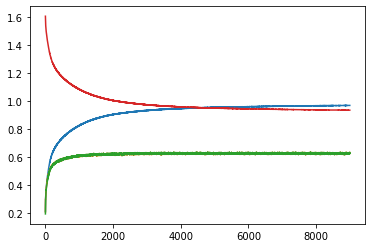

epoch: 0
train_acc: 0.969525
test_acc: 0.6242
f1: 0.6246999453908312

epoch: 1
train_acc: 0.96955
test_acc: 0.6237
f1: 0.6235889790969537

epoch: 2
train_acc: 0.969825
test_acc: 0.6282
f1: 0.6282018065983724

epoch: 3
train_acc: 0.969525
test_acc: 0.625
f1: 0.6246760333047621

epoch: 4
train_acc: 0.969225
test_acc: 0.6201
f1: 0.619831264880039

epoch: 5
train_acc: 0.969575
test_acc: 0.6243
f1: 0.6243138415568543

epoch: 6
train_acc: 0.96945
test_acc: 0.6242
f1: 0.624172919763068

epoch: 7
train_acc: 0.969325
test_acc: 0.626
f1: 0.6263112974295163

epoch: 8
train_acc: 0.969
test_acc: 0.6245
f1: 0.6252067181563197

epoch: 9
train_acc: 0.969425
test_acc: 0.6206
f1: 0.6216778732120315

epoch: 10
train_acc: 0.969725
test_acc: 0.6302
f1: 0.6308921823364897

epoch: 11
train_acc: 0.96965
test_acc: 0.6315
f1: 0.6316970736375077

epoch: 12
train_acc: 0.9696
test_acc: 0.6254
f1: 0.6250943261043914

epoch: 13
train_acc: 0.969425
test_acc: 0.623
f1: 0.6226373591137924

epoch: 14
train_acc: 0.969675

epoch: 118
train_acc: 0.96965
test_acc: 0.6243
f1: 0.624346543786469

epoch: 119
train_acc: 0.96955
test_acc: 0.6241
f1: 0.6243811692196687

epoch: 120
train_acc: 0.96975
test_acc: 0.6248
f1: 0.6249322875085589

epoch: 121
train_acc: 0.9696
test_acc: 0.629
f1: 0.6293175235182774

epoch: 122
train_acc: 0.96905
test_acc: 0.6194
f1: 0.6199645208337153

epoch: 123
train_acc: 0.970075
test_acc: 0.6198
f1: 0.6200712853569708

epoch: 124
train_acc: 0.9695
test_acc: 0.6223
f1: 0.6220673649556614

epoch: 125
train_acc: 0.96965
test_acc: 0.6245
f1: 0.6236117385517062

epoch: 126
train_acc: 0.969675
test_acc: 0.6258
f1: 0.6251413745166513

epoch: 127
train_acc: 0.97005
test_acc: 0.6221
f1: 0.6219407281011682

epoch: 128
train_acc: 0.969875
test_acc: 0.6301
f1: 0.6302478297528439

epoch: 129
train_acc: 0.97015
test_acc: 0.6285
f1: 0.6284687670911335

epoch: 130
train_acc: 0.969625
test_acc: 0.6274
f1: 0.6278823975004654

epoch: 131
train_acc: 0.969375
test_acc: 0.6257
f1: 0.6261002182378008

epoch

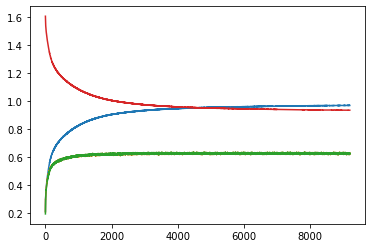

epoch: 0
train_acc: 0.970025
test_acc: 0.6235
f1: 0.6233616527218514

epoch: 1
train_acc: 0.96975
test_acc: 0.6268
f1: 0.6260286920811272

epoch: 2
train_acc: 0.969475
test_acc: 0.6187
f1: 0.6177639864442556

epoch: 3
train_acc: 0.9701
test_acc: 0.6294
f1: 0.6288718575078447

epoch: 4
train_acc: 0.9696
test_acc: 0.6247
f1: 0.6247632409441283

epoch: 5
train_acc: 0.96975
test_acc: 0.6241
f1: 0.6242235975063537

epoch: 6
train_acc: 0.9696
test_acc: 0.6247
f1: 0.6249272782122587

epoch: 7
train_acc: 0.97015
test_acc: 0.6233
f1: 0.6233938555053705

epoch: 8
train_acc: 0.969875
test_acc: 0.623
f1: 0.6223545807993802

epoch: 9
train_acc: 0.96965
test_acc: 0.6271
f1: 0.6270696232642843

epoch: 10
train_acc: 0.97005
test_acc: 0.6284
f1: 0.6284950150040343

epoch: 11
train_acc: 0.97005
test_acc: 0.6227
f1: 0.6238973729902302

epoch: 12
train_acc: 0.970125
test_acc: 0.6242
f1: 0.6250844127180202

epoch: 13
train_acc: 0.969775
test_acc: 0.6197
f1: 0.6201907030598068

epoch: 14
train_acc: 0.97015


epoch: 118
train_acc: 0.97
test_acc: 0.6191
f1: 0.6194716558484105

epoch: 119
train_acc: 0.96925
test_acc: 0.624
f1: 0.6242587633558698

epoch: 120
train_acc: 0.9698
test_acc: 0.6236
f1: 0.6237826986779967

epoch: 121
train_acc: 0.969825
test_acc: 0.6264
f1: 0.6261334028475558

epoch: 122
train_acc: 0.9702
test_acc: 0.6224
f1: 0.6223499014085463

epoch: 123
train_acc: 0.970525
test_acc: 0.6272
f1: 0.6263989339301189

epoch: 124
train_acc: 0.9698
test_acc: 0.63
f1: 0.6299416072703652

epoch: 125
train_acc: 0.97005
test_acc: 0.6284
f1: 0.628644963697485

epoch: 126
train_acc: 0.96975
test_acc: 0.6296
f1: 0.6304226722858293

epoch: 127
train_acc: 0.970125
test_acc: 0.6247
f1: 0.6248411843242107

epoch: 128
train_acc: 0.970175
test_acc: 0.6288
f1: 0.628997843321856

epoch: 129
train_acc: 0.97015
test_acc: 0.6292
f1: 0.6291549386909299

epoch: 130
train_acc: 0.96965
test_acc: 0.6235
f1: 0.6226414164656618

epoch: 131
train_acc: 0.9703
test_acc: 0.6298
f1: 0.6289149695461727

epoch: 132
tra

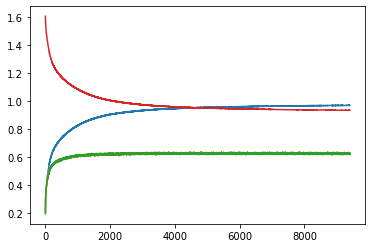

epoch: 0
train_acc: 0.9702
test_acc: 0.6239
f1: 0.6224985656059429

epoch: 1
train_acc: 0.970175
test_acc: 0.6283
f1: 0.6275422466753928

epoch: 2
train_acc: 0.970175
test_acc: 0.622
f1: 0.6223091081883263

epoch: 3
train_acc: 0.97085
test_acc: 0.6288
f1: 0.629923447706382

epoch: 4
train_acc: 0.970175
test_acc: 0.6199
f1: 0.6212098794921698

epoch: 5
train_acc: 0.969775
test_acc: 0.6288
f1: 0.6294186690374818

epoch: 6
train_acc: 0.97015
test_acc: 0.6251
f1: 0.6252050921810511

epoch: 7
train_acc: 0.9697
test_acc: 0.6258
f1: 0.6252018388748883

epoch: 8
train_acc: 0.9708
test_acc: 0.6265
f1: 0.625785467924096

epoch: 9
train_acc: 0.970425
test_acc: 0.6243
f1: 0.6237663679713115

epoch: 10
train_acc: 0.97095
test_acc: 0.6227
f1: 0.6230391265004253

epoch: 11
train_acc: 0.97025
test_acc: 0.6273
f1: 0.6275357083741114

epoch: 12
train_acc: 0.96945
test_acc: 0.6267
f1: 0.627038709720103

epoch: 13
train_acc: 0.969975
test_acc: 0.6246
f1: 0.6241057375988156

epoch: 14
train_acc: 0.970525
t

epoch: 118
train_acc: 0.970125
test_acc: 0.6263
f1: 0.6266412626724938

epoch: 119
train_acc: 0.970425
test_acc: 0.6205
f1: 0.6206783405926637

epoch: 120
train_acc: 0.970675
test_acc: 0.6242
f1: 0.6245130487006023

epoch: 121
train_acc: 0.970625
test_acc: 0.6272
f1: 0.6278154525053383

epoch: 122
train_acc: 0.970125
test_acc: 0.6251
f1: 0.6253495444395638

epoch: 123
train_acc: 0.969925
test_acc: 0.6249
f1: 0.6244545095677061

epoch: 124
train_acc: 0.970675
test_acc: 0.6252
f1: 0.6250851737923732

epoch: 125
train_acc: 0.9704
test_acc: 0.6206
f1: 0.6198577274158443

epoch: 126
train_acc: 0.970625
test_acc: 0.6285
f1: 0.6279537642685331

epoch: 127
train_acc: 0.97045
test_acc: 0.63
f1: 0.6301778331947396

epoch: 128
train_acc: 0.970325
test_acc: 0.6269
f1: 0.6275405493507661

epoch: 129
train_acc: 0.97065
test_acc: 0.6259
f1: 0.6267189156337104

epoch: 130
train_acc: 0.9704
test_acc: 0.625
f1: 0.6260834065165152

epoch: 131
train_acc: 0.97085
test_acc: 0.6221
f1: 0.6226839117185509

ep

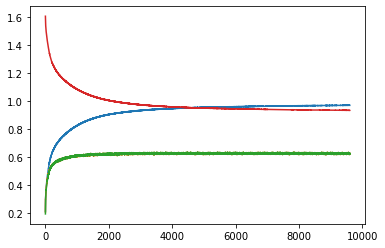

epoch: 0
train_acc: 0.9712
test_acc: 0.624
f1: 0.623848082298576

epoch: 1
train_acc: 0.9706
test_acc: 0.6226
f1: 0.6234732746971188

epoch: 2
train_acc: 0.9704
test_acc: 0.6207
f1: 0.6210474721875716

epoch: 3
train_acc: 0.970575
test_acc: 0.617
f1: 0.6170444720620726

epoch: 4
train_acc: 0.97035
test_acc: 0.625
f1: 0.624688490007456

epoch: 5
train_acc: 0.9704
test_acc: 0.628
f1: 0.6275906370818438

epoch: 6
train_acc: 0.970725
test_acc: 0.6251
f1: 0.6245552193562504

epoch: 7
train_acc: 0.970725
test_acc: 0.6247
f1: 0.6240349624946598

epoch: 8
train_acc: 0.970425
test_acc: 0.6241
f1: 0.6243089728041613

epoch: 9
train_acc: 0.970125
test_acc: 0.6286
f1: 0.6292376370294899

epoch: 10
train_acc: 0.9706
test_acc: 0.6223
f1: 0.622964169598496

epoch: 11
train_acc: 0.970825
test_acc: 0.6247
f1: 0.6250892805625421

epoch: 12
train_acc: 0.9712
test_acc: 0.6314
f1: 0.6307624187365812

epoch: 13
train_acc: 0.970125
test_acc: 0.625
f1: 0.624009012546435

epoch: 14
train_acc: 0.97085
test_acc:

epoch: 118
train_acc: 0.970975
test_acc: 0.6238
f1: 0.6232096452935124

epoch: 119
train_acc: 0.970725
test_acc: 0.6259
f1: 0.6261546616653337

epoch: 120
train_acc: 0.97135
test_acc: 0.6238
f1: 0.6239271826610387

epoch: 121
train_acc: 0.970975
test_acc: 0.6297
f1: 0.6298065628498505

epoch: 122
train_acc: 0.970425
test_acc: 0.6234
f1: 0.6233791173629719

epoch: 123
train_acc: 0.970575
test_acc: 0.6217
f1: 0.6220016866343252

epoch: 124
train_acc: 0.970575
test_acc: 0.6237
f1: 0.6237262621000405

epoch: 125
train_acc: 0.97065
test_acc: 0.6227
f1: 0.6230031337761708

epoch: 126
train_acc: 0.970525
test_acc: 0.6266
f1: 0.626744715029644

epoch: 127
train_acc: 0.9711
test_acc: 0.6237
f1: 0.623239740572464

epoch: 128
train_acc: 0.97135
test_acc: 0.6255
f1: 0.6254851071168697

epoch: 129
train_acc: 0.9707
test_acc: 0.6229
f1: 0.6232685038865601

epoch: 130
train_acc: 0.971125
test_acc: 0.6241
f1: 0.6243020939258652

epoch: 131
train_acc: 0.970675
test_acc: 0.6298
f1: 0.6306101022484675

e

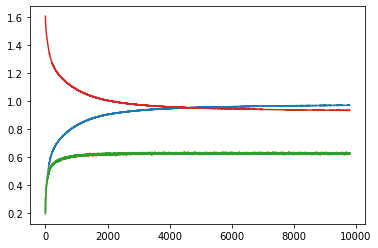

epoch: 0
train_acc: 0.97125
test_acc: 0.6234
f1: 0.6239360630840817

epoch: 1
train_acc: 0.970725
test_acc: 0.62
f1: 0.6203361609658561

epoch: 2
train_acc: 0.971275
test_acc: 0.6206
f1: 0.6201242310288869

epoch: 3
train_acc: 0.970775
test_acc: 0.6179
f1: 0.6173589074104655

epoch: 4
train_acc: 0.971475
test_acc: 0.6258
f1: 0.625554050639597

epoch: 5
train_acc: 0.9703
test_acc: 0.6281
f1: 0.6281608693087739

epoch: 6
train_acc: 0.971
test_acc: 0.6261
f1: 0.6269489323136304

epoch: 7
train_acc: 0.971475
test_acc: 0.6259
f1: 0.6264836472518984

epoch: 8
train_acc: 0.97085
test_acc: 0.6246
f1: 0.6250465457262894

epoch: 9
train_acc: 0.970825
test_acc: 0.6216
f1: 0.6215366961103916

epoch: 10
train_acc: 0.971125
test_acc: 0.6239
f1: 0.6238760798730367

epoch: 11
train_acc: 0.971125
test_acc: 0.6255
f1: 0.6255350794098685

epoch: 12
train_acc: 0.97105
test_acc: 0.6277
f1: 0.6273976002689693

epoch: 13
train_acc: 0.97095
test_acc: 0.6215
f1: 0.6211747688048266

epoch: 14
train_acc: 0.97087

epoch: 118
train_acc: 0.971175
test_acc: 0.6227
f1: 0.6228420924909498

epoch: 119
train_acc: 0.9713
test_acc: 0.6236
f1: 0.6235023547212136

epoch: 120
train_acc: 0.97115
test_acc: 0.6211
f1: 0.6205658654682977

epoch: 121
train_acc: 0.97105
test_acc: 0.6223
f1: 0.6221782814811379

epoch: 122
train_acc: 0.971175
test_acc: 0.6245
f1: 0.6244657936566914

epoch: 123
train_acc: 0.970775
test_acc: 0.6278
f1: 0.6281449623579803

epoch: 124
train_acc: 0.97085
test_acc: 0.6244
f1: 0.6248957909930893

epoch: 125
train_acc: 0.971125
test_acc: 0.6231
f1: 0.6233501398672304

epoch: 126
train_acc: 0.9709
test_acc: 0.6237
f1: 0.6236040989239308

epoch: 127
train_acc: 0.9714
test_acc: 0.6209
f1: 0.6205028207827546

epoch: 128
train_acc: 0.971075
test_acc: 0.623
f1: 0.6228018040347099

epoch: 129
train_acc: 0.970975
test_acc: 0.6251
f1: 0.625239473302429

epoch: 130
train_acc: 0.970825
test_acc: 0.6221
f1: 0.6218126433996395

epoch: 131
train_acc: 0.970925
test_acc: 0.622
f1: 0.621944922862003

epoch

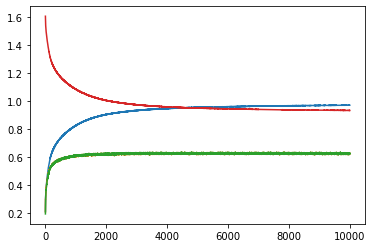

In [10]:
for i in range(50):
    for epoch in range(epochs):
        y_pred = net.forward(X_train)

        train_pred = y_pred.cpu().detach().numpy()
        train_pred = [np.argmax(sample) for sample in train_pred]
        train_accuracy = accuracy_score(y_train.cpu(), train_pred)
        train_accuracies.append(train_accuracy)

        test_pred = net.predict(X_test)
        test_accuracy = accuracy_score(y_test.cpu(), test_pred)
        test_accuracies.append(test_accuracy)
        
        f1 = f1_score(y_test.cpu(), test_pred, average='weighted')
        f1s.append(f1)

        loss = criterion(y_pred, y_train)
        losses.append(loss)
        
        print("epoch:", epoch)
        print("train_acc:", train_accuracy)
        print("test_acc:", test_accuracy)
        print("f1:", f1)
        print()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    plt.plot(train_accuracies)
    plt.plot(test_accuracies)
    plt.plot(f1s)
    plt.plot(losses)
    plt.show()
    
    torch.save(net.state_dict(), 'torch_num_chiral_dict.dict')

In [11]:
from sklearn.metrics import confusion_matrix
test_pred = net.predict(X_test)
confusion_matrix(y_test.cpu(), test_pred)

array([[1435,  303,  143,   44,   38],
       [ 252, 1176,  353,  149,   44],
       [ 129,  359, 1042,  326,  154],
       [  43,  155,  371, 1166,  332],
       [  20,   47,  133,  384, 1402]])

In [6]:
torch.save(net, 'torch_num_chiral.mdl')